# Разработка персонализированных предложений пользователям сервиса "В один клик"

**Описание проекта:** руководство сервиса по онлайн-продаже различных товаров "В один клик" обратилось в отдел цифровых технологий с проблемой снижения активности покупателей. Возможным решением задачи может послужить удерживание активности постоянных клиентов с помощью персонализированных предложений.

Цель работы: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования:**
* Подготовка данных: загрузка и изучение общей информации из представленного датасета;
* Предобработка данных: переименование столбцов, обработка пропущенных значений, корректировка типа данных, обработка дубликатов и других аномалий;
* Исследовательский анализ данных: изучение основных характеристик, их распределение;
* Корреляционный анализ: поиск зависимостей между характеристиками;
* Поиск лучшей классификационной модели-МО для предсказания снижения покупательской активности клиентов сервиса в ближайшие 3 месяца;
* Анализ важности признаков;
* Сегментация покупателей, разработка персонализированных предложений;

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Загрузка данных

Загрузим необходимые библиотеки

In [1]:
!pip install phik -q
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
import scipy.stats
from sklearn.metrics import  mean_squared_error, accuracy_score, confusion_matrix, recall_score, roc_auc_score, make_scorer, fbeta_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Загрузим данные

In [3]:
try:
    site_info_df = pd.read_csv('/datasets/market_file.csv')
    gain_df = pd.read_csv('/datasets/market_money.csv')
    time_df = pd.read_csv('/datasets/market_time.csv')
    money_df = pd.read_csv('/datasets/money.csv',sep = ';', decimal=',')
except:
    site_info_df = pd.read_csv('F:\\Учеба яндекс\\projects\\7_one_click\\market_file.csv')
    gain_df = pd.read_csv('F:\\Учеба яндекс\\projects\\7_one_click\\market_money.csv')
    time_df = pd.read_csv('F:\\Учеба яндекс\\projects\\7_one_click\\market_time.csv')
    money_df = pd.read_csv('F:\\Учеба яндекс\\projects\\7_one_click\\money.csv',sep = ';', decimal=',')

**Изучим данные**

In [4]:
def first_look(df):
    return display(df.info(),df.describe(),df.head(10))

Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

In [5]:
first_look(site_info_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


При первом взгляде пропуски, выбивающиеся значения не видны, возможно наличие неявных дубликатов.

In [6]:
first_look(gain_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


Наличие 3-ех категорий в столбце "Период" обуславливает наличие возросшего в 3 раза количества записей.

In [7]:
first_look(time_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Наличие 2-ух категорий в столбце "Период" обуславливает наличие возросшего в 2 раза количества записей. При записи данных произошла ошибка: в столбце "период" неправильно записана категория "предыдущий_месяц"

In [8]:
first_look(money_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


**Вывод:** предварительный анализ предоставленных данных показывает: данные достаточно логичны, выбивающихся значений предварительно не обнаружено, явные пропуски отсутствуют. Необходима предобработка данных: приведение наименований столбцов к нижнему регистру, поиск дубликатов, исправление ошибок в записанных данных. Также из описания задания не понятно, что подразумевается и в каких единицах измеряется "прибыль".

## Предобработка данных

**Переименование столбцов**

In [9]:
DFs = [site_info_df, gain_df, time_df, money_df]

In [10]:
for df in DFs:
    df.columns = df.columns.str.lower()

In [11]:
site_info_df.rename(columns = {'покупательская активность': 'покупательская_активность',
                               'тип сервиса' : 'тип_сервиса', 'разрешить сообщать':'рассылка'}, inplace = True)

In [12]:
time_df.rename(columns = {'минут': 'время,м'}, inplace = True)

**Приведение значений к нижнему регистру**

In [13]:
site_info_df['покупательская_активность'] = site_info_df['покупательская_активность'].str.lower()

**Обработка пропусков**

In [14]:
for df in DFs:
    print(f'Количество пропусков: {df.isna().sum()["id"]} \n')

Количество пропусков: 0 

Количество пропусков: 0 

Количество пропусков: 0 

Количество пропусков: 0 



**Поиск явных дубликатов**

In [15]:
for df in DFs:
    print(f'Количество явных дубликатов: {df.duplicated().sum()} \n')

Количество явных дубликатов: 0 

Количество явных дубликатов: 0 

Количество явных дубликатов: 0 

Количество явных дубликатов: 0 



**Поиск неявных дубликатов**

**Проверим наличие дубликатов в столбце "id" в датасете с информацией с сайта сервиса**

In [16]:
site_info_df['id'].duplicated().sum()

0

**Проверим уникальные значения в столбце "тип сервиса"**

In [17]:
site_info_df['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Необходимо избавится от дублирующего значения "стандартт"

In [18]:
site_info_df.loc[site_info_df['тип_сервиса'] == 'стандартт','тип_сервиса'] = 'стандарт'

Вероятнее всего категория "стандартт" появилась из-за ошибки при ручном вводе данных.

**Исправление ошибки при записи категории в датасете с данными о времени, проводимом на сайте**

In [19]:
def mistake_correction(mistake):
    if mistake == 'предыдцщий_месяц':
        return 'предыдущий_месяц'
    else:
        return mistake
time_df['период'] = time_df['период'].map(mistake_correction)

**Вывод:** выполнено приведение к нижнему регистру наименований столбцов, а также значений в столбце "покупательская_активность", проверено наличие дубликатов и пропусков, исправлены ошибки, допущенные при записи данных. Данные достаточно чистые; пропуски, явные дубликаты в данных отсутствуют.

## Исследовательский анализ данных

Проверим наличие пользователей, не совершавших покупки в течении указанного периода:

In [20]:
bad_id = gain_df.query('выручка == 0')['id'].unique()
bad_id

array([215348, 215357, 215359])

Таким образом, в датасете есть информация о 3-ех пользователях, которые совершали покупки менее 3-ех месяцев. Для дальнейшего анализа они не подходят.

In [21]:
gain_df = gain_df.query('id not in @bad_id')

Напишем функции для анализа числовых и категориальных признаков:

In [22]:
def num_feature_site_info(name):
    print(f'Основные описательные статистики {site_info_df[name].name} со сниженной покупательской активностью')
    display(site_info_df.query('покупательская_активность == "снизилась"')[name].describe())
    print(f'Основные описательные статистики {site_info_df[name].name} с покупательской активностью на прежнем уровне')
    display(site_info_df.query('покупательская_активность == "прежний уровень"')[name].describe())
    sns.boxplot(data = site_info_df, y = name, x = 'покупательская_активность', order = ['снизилась','прежний уровень'])
    plt.title(f'Диаграмма размаха {site_info_df[name].name}', size = 15)
    plt.xlabel(site_info_df[name].name, size = 12)
    plt.show()
    site_info_df.query('покупательская_активность == "снизилась"')[name].hist(bins = 15,
                                                                              figsize = (9,7),
                                                                              edgecolor='black',
                                                                              label = 'активность снизилась',
                                                                              alpha = 0.5)
    site_info_df.query('покупательская_активность == "прежний уровень"')[name].hist(bins = 15,
                                                                                    figsize = (9,7),
                                                                                    edgecolor='black',
                                                                                    label = 'активность не изменилась',
                                                                                    alpha = 0.5)
    plt.title(f'Гистограмма {site_info_df[name].name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(site_info_df[name].name, size = 12)
    plt.legend()
    plt.show()

In [23]:
def cat_feature_site_info(name):
    display(f'Количество уникальных значений в столбце равно {site_info_df[name].nunique()}')
    display(f'Для сниженной покупательской активности:')
    print(site_info_df.query('покупательская_активность == "снизилась"')[name].value_counts())
    
    display(f'Для прежней покупательской активности:')
    print(site_info_df.query('покупательская_активность == "прежний уровень"')[name].value_counts())

#построение диаграмм
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

    
    values = site_info_df.query('покупательская_активность == "снизилась"')[name].value_counts()
    ax1.pie(x = values,
            labels = site_info_df.query('покупательская_активность == "снизилась"')[name].value_counts().index,
            autopct = '%1.1f%%')
    ax1.set_title(f'{site_info_df[name].name} ПА снижена')
    values = site_info_df.query('покупательская_активность == "прежний уровень"')[name].value_counts()
    ax2.pie(x = values,
            labels = site_info_df.query('покупательская_активность == "прежний уровень"')[name].value_counts().index,
            autopct = '%1.1f%%') #plot second pie
    ax2.set_title(f'{site_info_df[name].name} ПА на прежнем уровне')

    plt.show()

In [24]:
def num_feature(data):
    display(data.describe())
    data.plot(kind = 'box', grid = True, figsize = (9,7))
    plt.title(f'Диаграмма размаха {data.name}', size = 15)
    plt.xlabel(data.name, size = 12)
    plt.show()
    data.hist(bins = 15, figsize = (9,7), edgecolor='black')
    plt.title(f'Гистограмма {data.name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(data.name, size = 12)
    plt.show()

In [25]:
def cat_feature(data):
    display(f'Количество уникальных значений в столбце равно {data.nunique()}')
    display(data.value_counts())
    data.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', figsize = (9, 7))
    plt.title(f'Круговая диаграмма {data.name}', size = 15)
    plt.show()

### Покупательская активность

'Количество уникальных значений в столбце равно 2'

прежний уровень    802
снизилась          498
Name: покупательская_активность, dtype: int64

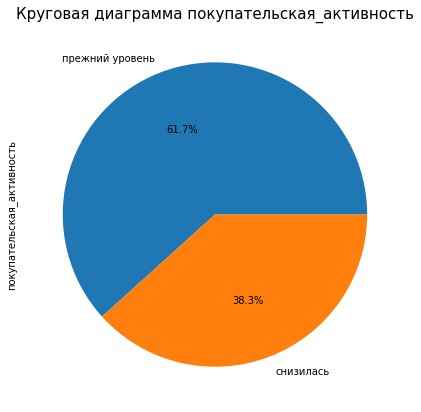

In [26]:
cat_feature(site_info_df['покупательская_активность'])

Как видно из представленных данных большинство пользователей сохранили свою покупательскую активность(ПА).

### Признаки, описывающие коммуникацию сотрудников компании с клиентом

#### Тип сервиса

'Количество уникальных значений в столбце равно 2'

'Для сниженной покупательской активности:'

стандарт    328
премиум     170
Name: тип_сервиса, dtype: int64


'Для прежней покупательской активности:'

стандарт    596
премиум     206
Name: тип_сервиса, dtype: int64


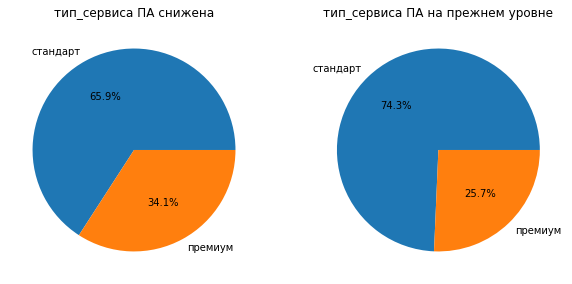

In [27]:
cat_feature_site_info('тип_сервиса')

Всего представлено 2 типа сервиса, преобладающее большинство пользователей предпочитает стандартный.

Невозможно однозначно сказать о наличии влияния типа сервиса на покупательскую активность.

#### Наличие рассылки

'Количество уникальных значений в столбце равно 2'

'Для сниженной покупательской активности:'

да     371
нет    127
Name: рассылка, dtype: int64


'Для прежней покупательской активности:'

да     591
нет    211
Name: рассылка, dtype: int64


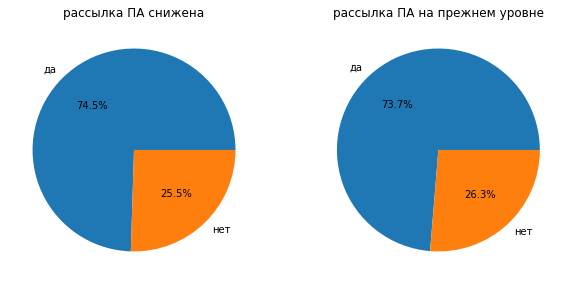

In [28]:
cat_feature_site_info('рассылка')

Большинство клиентов согласно на получение рассылки.

Вероятнее всего наличие рассылки не влияет на покупательскую активность, что заметно из приведенных относительных значений.

#### Среднемесячное значение маркетинговых коммуникаций компании за послединие 6 месяцев

Основные описательные статистики маркет_актив_6_мес со сниженной покупательской активностью


count    498.000000
mean       3.744378
std        1.053374
min        0.900000
25%        3.100000
50%        3.900000
75%        4.400000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

Основные описательные статистики маркет_актив_6_мес с покупательской активностью на прежнем уровне


count    802.000000
mean       4.570075
std        0.848618
min        0.900000
25%        4.000000
50%        4.400000
75%        5.275000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

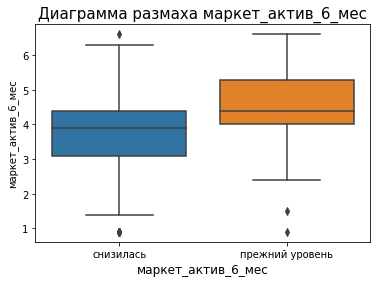

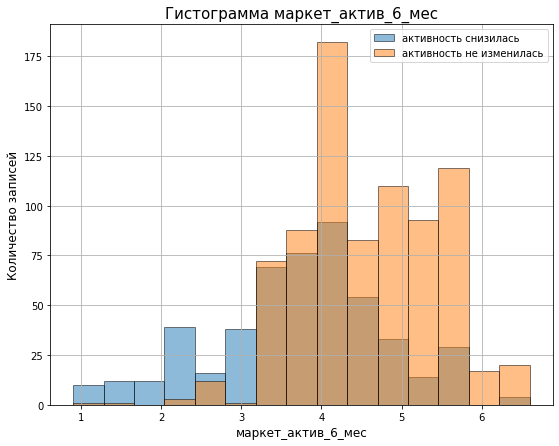

In [29]:
num_feature_site_info('маркет_актив_6_мес')

Распределение стремится к нормальному. Преобладающее большинство в среднем коммуницирует с сотрудниками 4 раза в месяц.

Вероятнее всего существует зависимость между количеством маркетиновых коммуникаций и покупательской активностью, так как у пользователей с прежней активностью среднее количество и мода среднемесячного значения маркетинговых коммуникаций больше, нежели у пользователей со снизившейся ПА.

#### Количество маркетинговых коммуникаций в текущем месяце

'Количество уникальных значений в столбце равно 3'

'Для сниженной покупательской активности:'

4    248
5    128
3    122
Name: маркет_актив_тек_мес, dtype: int64


'Для прежней покупательской активности:'

4    421
5    195
3    186
Name: маркет_актив_тек_мес, dtype: int64


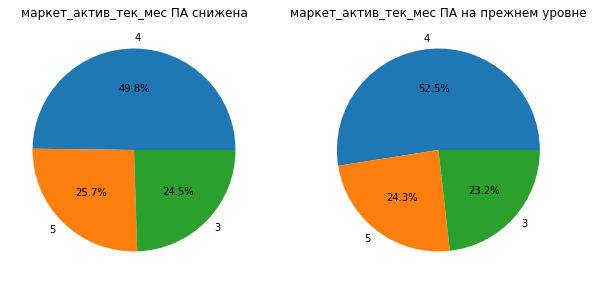

In [30]:
cat_feature_site_info('маркет_актив_тек_мес')

Из распределения видно, что количество маркетинговых коммуникаций в текущем месяце может равно 3, 4 и 5. На бОльшую часть клиентов приходится по 4 маркетинговых коммуникации.

Невозможно однозначно сказать о наличии влияния количества маркетинговых коммуникаций в текущем месяце на покупательскую активность.

#### Количество дней с момента регистрации

Основные описательные статистики длительность со сниженной покупательской активностью


count     498.000000
mean      619.883534
std       239.940818
min       110.000000
25%       449.000000
50%       634.500000
75%       811.000000
max      1079.000000
Name: длительность, dtype: float64

Основные описательные статистики длительность с покупательской активностью на прежнем уровне


count     802.000000
mean      590.730673
std       255.330179
min       121.000000
25%       382.500000
50%       590.000000
75%       798.750000
max      1061.000000
Name: длительность, dtype: float64

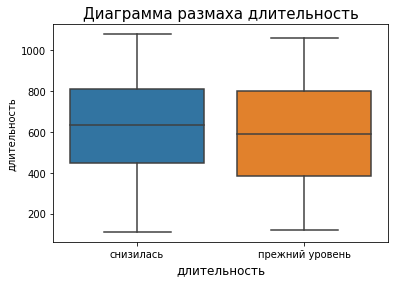

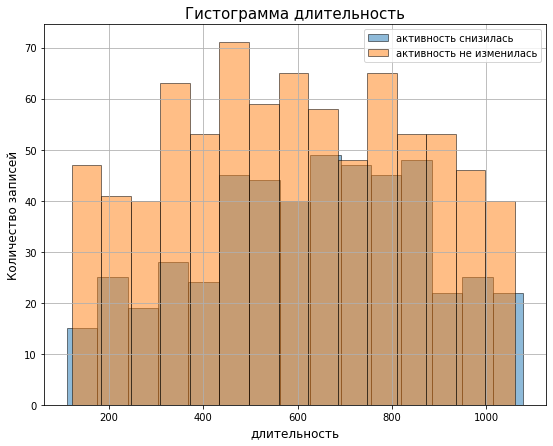

In [31]:
num_feature_site_info('длительность')

В последнее время стало меньше новых пользователей.

Вероятнее всего существует зависимость между длительностью пользования сервисом и покупательской активностью, так как у пользователей с прежней активностью среднее количество и мода длительности больше, нежели у пользователей со снизившейся ПА. При этом можно заметить следующее: распределение длительности у пользователей с прежней ПА ровнее, в то время как пользователи, у которых ПА снизилась, в основной своей массе пришли 500-800 дней назад. Необходимо попросить заказчика предоставить дополнительные данные о проведении различных акций и скидок, чтобы проверить, что могло повлиять на привлечение пользователей с тенденцией к снижению ПА.

### Признаки, описывающие продуктовое поведение

#### Популярная категория

'Количество уникальных значений в столбце равно 6'

'Для сниженной покупательской активности:'

Товары для детей                        146
Косметика и аксесуары                   105
Домашний текстиль                       102
Кухонная посуда                          66
Техника для красоты и здоровья           52
Мелкая бытовая техника и электроника     27
Name: популярная_категория, dtype: int64


'Для прежней покупательской активности:'

Товары для детей                        184
Домашний текстиль                       149
Мелкая бытовая техника и электроника    147
Техника для красоты и здоровья          132
Косметика и аксесуары                   118
Кухонная посуда                          72
Name: популярная_категория, dtype: int64


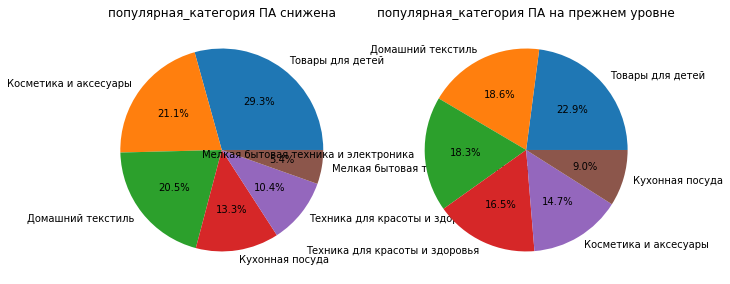

In [32]:
cat_feature_site_info('популярная_категория')

Большая часть покупок в магазине приходится на товары для детей.

Можно заметить, что у всех пользователей наиболее популярная категория покупок - товары для детей, далее распределение категорий меняется: у пользователей со сниженной ПА на втором месте - косметика и аксессуары, на третьем - домашний текстить, на четвертом - кухонная посуда; у пользователей с прежней ПА на втором месте - домашний текстиль, на третьем - мелкая бытовая техника и электроника, на четвертом - техника для красоты и здоровья.

#### Среднее количество просмотренных категорий товаров за визит

Основные описательные статистики средний_просмотр_категорий_за_визит со сниженной покупательской активностью


count    498.000000
mean       2.632530
std        1.229871
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

Основные описательные статистики средний_просмотр_категорий_за_визит с покупательской активностью на прежнем уровне


count    802.000000
mean       3.665835
std        1.277112
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

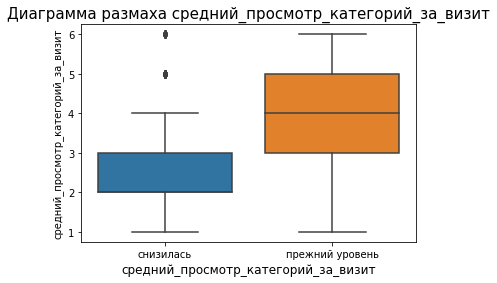

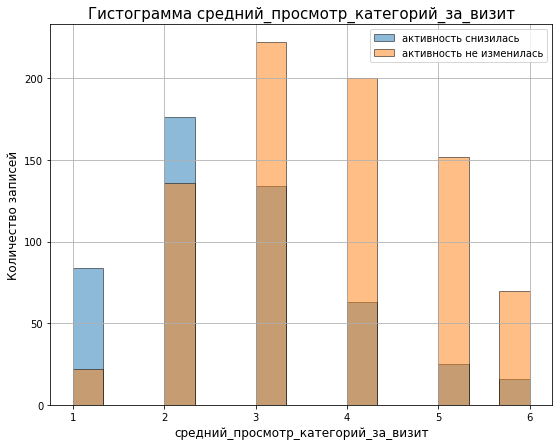

In [33]:
num_feature_site_info('средний_просмотр_категорий_за_визит')

Распределение не является непрерывным.

Заметно наличие влияния среднего числа просмотренных категорий за визит: у пользователей со сниженной ПА - меньше, у пользователей с неизменной ПА - больше.

#### Число неоплаченных товаров в корзине за последние 3 месяца

Основные описательные статистики неоплаченные_продукты_штук_квартал со сниженной покупательской активностью


count    498.000000
mean       3.720884
std        2.287312
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Основные описательные статистики неоплаченные_продукты_штук_квартал с покупательской активностью на прежнем уровне


count    802.000000
mean       2.293017
std        1.508255
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

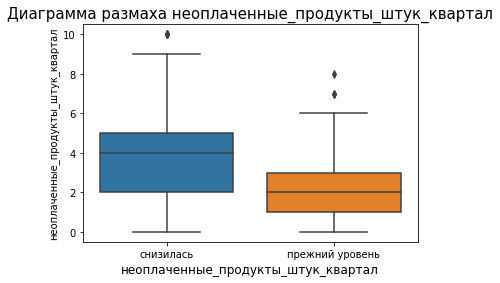

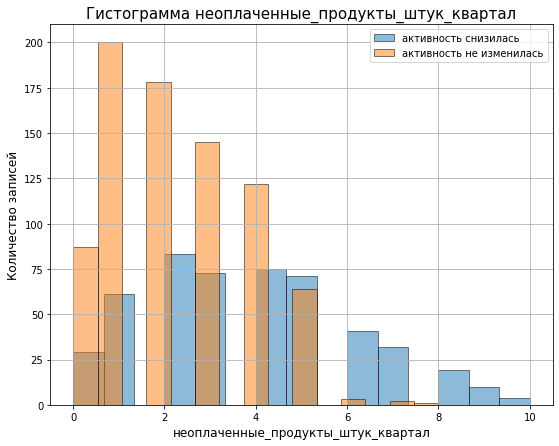

In [34]:
num_feature_site_info('неоплаченные_продукты_штук_квартал')

Более половины клиентов имеет от 0 до 3 неоплаченных товаров в корзине.

Также заметно наличие зависимости: у пользователей с малым числом неоплаченных товаров в корзине больше вероятность сохранить ПА, в то время как пользователи со снизившейся ПА предпочитают копить товары в корзине.

### Признаки, описывающие поведение пользователей на сайте

#### Время на сайте

Построим диаграмму размаха времени, проведенном на сайте

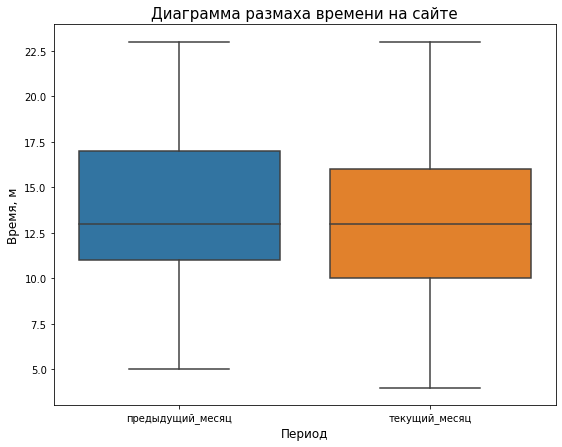

In [35]:
plt.figure(figsize=(9,7))
sns.boxplot(data = time_df, y = 'время,м', x = 'период', order = ['предыдущий_месяц','текущий_месяц'])
plt.title('Диаграмма размаха времени на сайте', size = 15)
plt.xlabel('Период', size = 12)
plt.ylabel('Время, м', size = 12)
plt.show()

Из диаграммы размаха видно, что пользователи стали проводить меньше времени на сайте.

Построим гистограмму распределения времени, проведенном на сайте

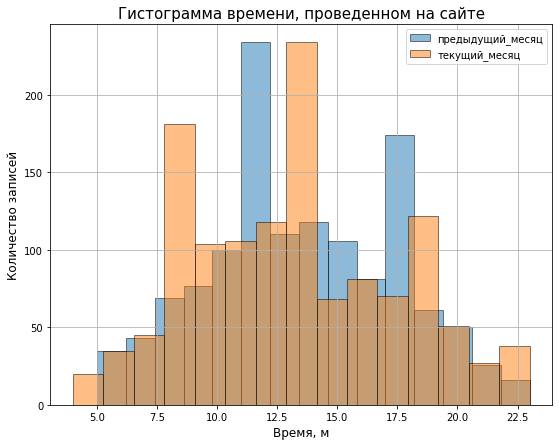

In [36]:
time_df.query('период == "предыдущий_месяц"')['время,м'].hist(bins = 15,
                                                              figsize = (9,7),
                                                              edgecolor='black',
                                                              label = 'предыдущий_месяц',
                                                              alpha = 0.5)
time_df.query('период == "текущий_месяц"')['время,м'].hist(bins = 15,
                                                           figsize = (9,7),
                                                           edgecolor='black',
                                                           label = 'текущий_месяц',
                                                           alpha = 0.5)
plt.title(f'Гистограмма времени, проведенном на сайте', size = 15)
plt.legend()
plt.xlabel('Время, м', size = 12)
plt.ylabel('Количество записей', size = 12)
plt.show()

Распределение времени стремится к нормальному.

#### Число сбоев

Основные описательные статистики ошибка_сервиса со сниженной покупательской активностью


count    498.000000
mean       3.943775
std        1.892709
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: ошибка_сервиса, dtype: float64

Основные описательные статистики ошибка_сервиса с покупательской активностью на прежнем уровне


count    802.000000
mean       4.335411
std        1.979538
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max        9.000000
Name: ошибка_сервиса, dtype: float64

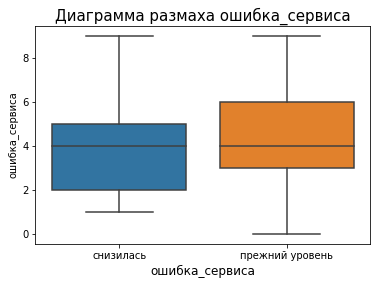

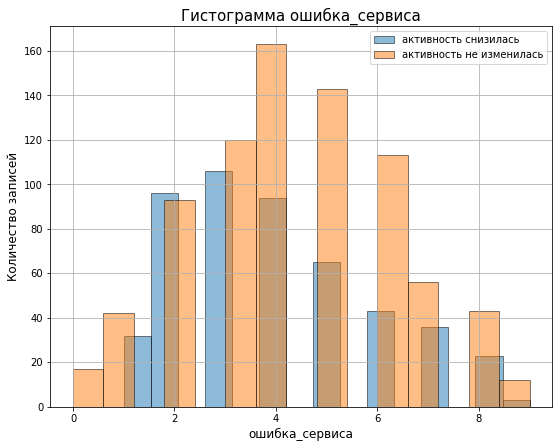

In [37]:
num_feature_site_info('ошибка_сервиса')

В среднем люди сталкиваются с 4 ошибками сервиса.

Пользователи, ПА которых снизилась, сталкиваются с меньшим количеством ошибок, нежели пользователи с ПА на прежнем уровне. Однако это не говорит о наличии зависимости, а может быть следствием того, что пользователи с ПА на прежнем уровне проводят на сайте больше времени и соответственно чаще встречаются с ошибками сервиса.

#### Среднее количество страниц за визит

Основные описательные статистики страниц_за_визит со сниженной покупательской активностью


count    498.000000
mean       5.568273
std        3.454265
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       18.000000
Name: страниц_за_визит, dtype: float64

Основные описательные статистики страниц_за_визит с покупательской активностью на прежнем уровне


count    802.000000
mean       9.796758
std        3.376846
min        3.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       20.000000
Name: страниц_за_визит, dtype: float64

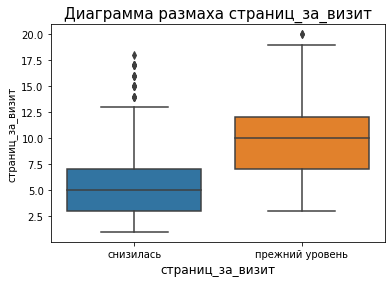

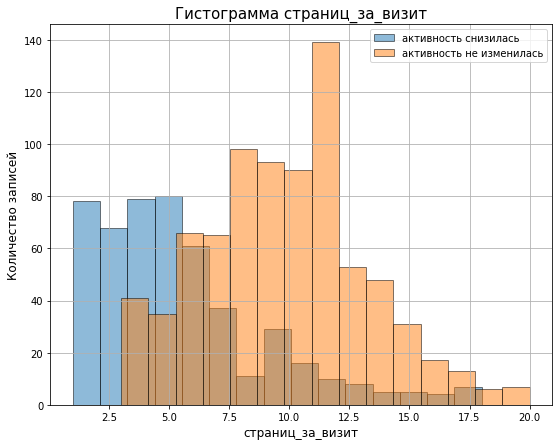

In [38]:
num_feature_site_info('страниц_за_визит')

Распределение стремится к нормальному. В среднем люди просматривают 8 страниц за визит.

Вероятнее всего существует зависимость между количеством посещенных за визит страниц и покупательской активностью, так как у пользователей с прежней активностью среднее количество и мода посещенных за визит страниц больше, нежели у пользователей со снизившейся ПА.

### Признаки, описывающие финансовое поведение пользователей

#### Доля покупок по акции от общего числа покупок за последние 6 месяцев

Основные описательные статистики акционные_покупки со сниженной покупательской активностью


count    498.000000
mean       0.450964
std        0.306011
min        0.000000
25%        0.240000
50%        0.310000
75%        0.890000
max        0.990000
Name: акционные_покупки, dtype: float64

Основные описательные статистики акционные_покупки с покупательской активностью на прежнем уровне


count    802.000000
mean       0.238367
std        0.160599
min        0.110000
25%        0.150000
50%        0.210000
75%        0.260000
max        0.990000
Name: акционные_покупки, dtype: float64

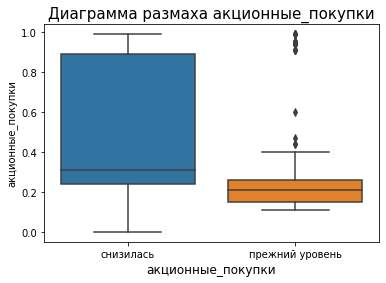

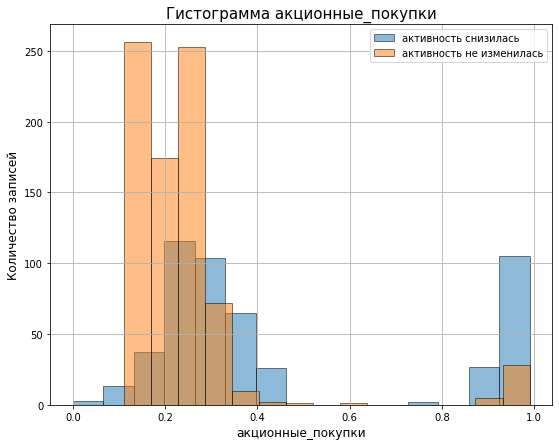

In [39]:
num_feature_site_info('акционные_покупки')

In [40]:
site_info_df.query('акционные_покупки> 0.5')

,id,покупательская_активность,тип_сервиса,рассылка,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1,215349,снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
14,215362,снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4
16,215364,снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,216602,прежний уровень,стандарт,нет,3.4,5,170,0.95,Техника для красоты и здоровья,4,1,3,10
1256,216604,прежний уровень,стандарт,да,4.9,5,350,0.99,Домашний текстиль,3,4,5,5
1257,216605,прежний уровень,стандарт,да,3.2,4,568,0.94,Мелкая бытовая техника и электроника,5,1,7,11
1292,216640,прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,3,5,13


Данных с долей акционных покупок более половины более 10%, мы не можем ими пожертвовать. Скорее всего данные описывают различные категории покупателей. Величина распределена нормально с двумя вершинами.

Вероятнее всего существует зависимость между количеством долей акционных покупок и покупательской активностью, так как у пользователей с прежней активностью среднее количество и мода доли акционных покупок меньше, нежели у пользователей со снизившейся ПА. Однако, все же есть пользователи, доля акционных покупок которых превышает 90% при сохранившейся ПА.

#### Выручка

Построим распределение выручки в зависимости от периода

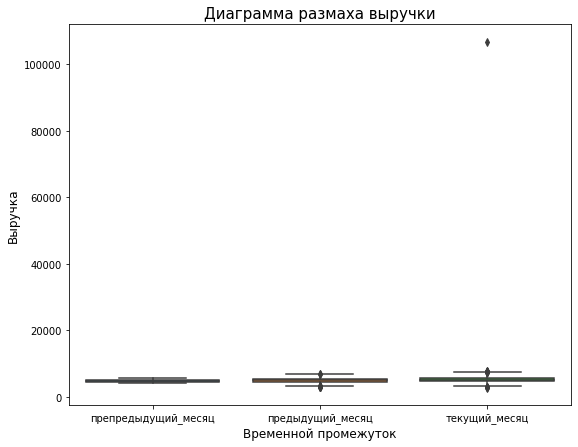

In [41]:
plt.figure(figsize=(9,7))
sns.boxplot(data = gain_df, y = 'выручка', x = 'период', order = ['препредыдущий_месяц','предыдущий_месяц','текущий_месяц'])
plt.title('Диаграмма размаха выручки', size = 15)
plt.xlabel('Временной промежуток', size = 12)
plt.ylabel('Выручка', size = 12)
plt.show()

На диаграмме виден выброс с выручкой более 100000.

In [42]:
gain_df.query('выручка > 10000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


Датасет не имеет ни одной записи с выручкой более 10 тыс, не считая выброса.

Проанализируем траты клиента в остальные месяцы.

In [43]:
gain_df[gain_df['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


В остальные месяцы выручка не превышала 6.5 тысяч => вероятно, что при записи данных была допущена ошибка. Также не подойдет снижение данного выброса в 100 раз, так как выручка не опускалась ниже 5 тыс. Поэтому считаю наиболее разумным исключение данного пользователя из дальнейшего анализа и построения моделей МО, а также поместим id в индекс.

In [44]:
gain_df = gain_df[gain_df['id'] != 215380]

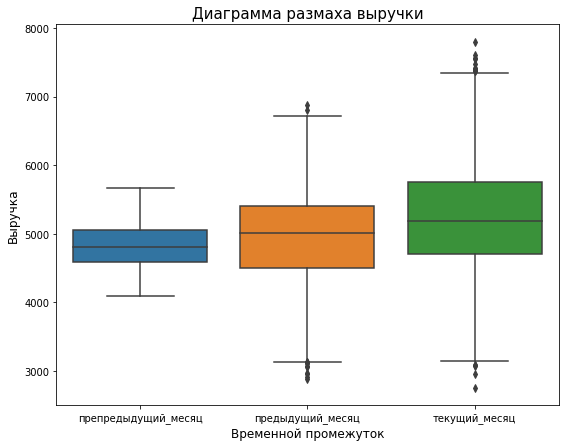

In [45]:
plt.figure(figsize=(9,7))
sns.boxplot(data = gain_df, y = 'выручка', x = 'период', order = ['препредыдущий_месяц','предыдущий_месяц','текущий_месяц'])
plt.title('Диаграмма размаха выручки', size = 15)
plt.xlabel('Временной промежуток', size = 12)
plt.ylabel('Выручка', size = 12)
plt.show()

Построим гистограмму выручки

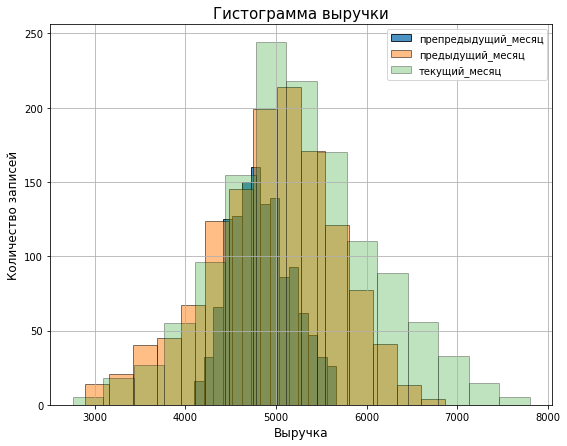

In [46]:
gain_df.query('период == "препредыдущий_месяц"')['выручка'].hist(bins = 15,
                                                                figsize = (9,7),
                                                                edgecolor='black',
                                                                label = 'препредыдущий_месяц',
                                                                alpha = 0.8)
gain_df.query('период == "предыдущий_месяц"')['выручка'].hist(bins = 15,
                                                                figsize = (9,7),
                                                                edgecolor='black',
                                                                label = 'предыдущий_месяц',
                                                                alpha = 0.5)
gain_df.query('период == "текущий_месяц"')['выручка'].hist(bins = 15,
                                                           figsize = (9,7),
                                                           edgecolor='black',
                                                           label = 'текущий_месяц',
                                                           alpha = 0.3)
plt.title(f'Гистограмма выручки', size = 15)
plt.legend()
plt.xlabel('Выручка', size = 12)
plt.ylabel('Количество записей', size = 12)
plt.show()

Распределение выручки стремится к нормальному, от месяца к месяцу средняя выручка растет, однако разброс выручки также  увеличивается.

### Прибыль

Проведем исследовательский анализ данных

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

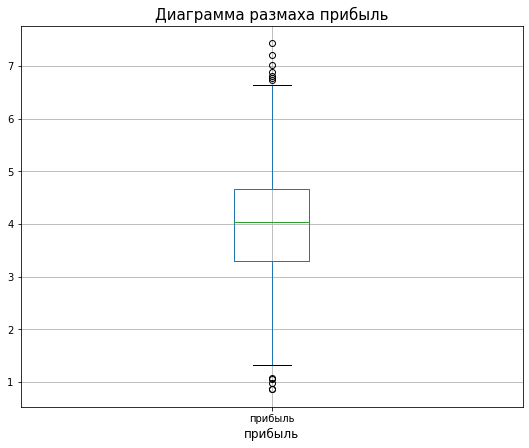

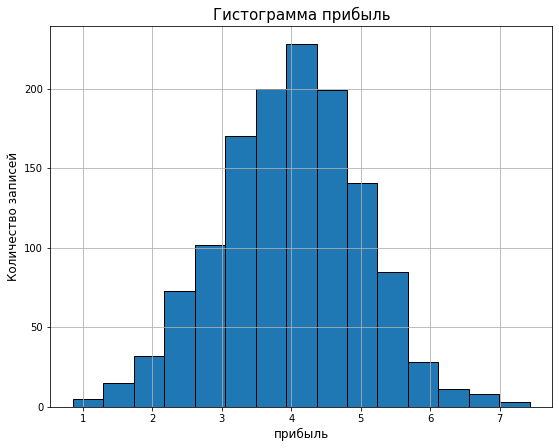

In [47]:
num_feature(money_df['прибыль'])

Распределение прибыли стремится к нормальному со средним около 4-ёх.

**Вывод:** Проведен исследовательский анализ данных с разделением признаков по категориям. 
1) Анализ покупательскй активности показал, что большинство пользователей сохранили свою активность.

2) Признаки, описывающие коммуникацию сотрудников компании с клиентом: 
* тип сервиса - представлено 2 типа сервиса, большинство выбирает стандартный;
* наличие рассылки - большинство согласно на получение рекламной рассылки;
* среднемесячное значение маркетинговых коммуникаций компании за послединие 6 месяцев - преобладающее большинство в среднем коммуницирует с сотрудниками 4 раза в месяц, у пользователей с прежней активностью среднее количество и мода среднемесячного значения маркетинговых коммуникаций больше, нежели у пользователей со снизившейся ПА;
* количество маркетинговых коммуникаций в этом месяце - преобладающее большинство 4 раза;
* количество дней с момента регистрации - распределение стремится к нормальному со средним в 602 дня, распределение длительности у пользователей с прежней ПА ровнее, в то время как пользователи, у которых ПА снизилась, в основной своей массе пришли 500-800 дней назад.

3) Признаки, описывающие продуктовое поведение пользователей:
* популярная категория - бОльшая часть покупок в магазине приходится на товары для детей;
* среднее количество просмотренных категорий товаров за визит - наиболее часто смотрят 3 категории за визит, у пользователей со сниженной ПА - меньше, у пользователей с неизменной ПА - больше;
* число неоплаченных товаров в корзине за последние 3 месяца - более половины клиентов имеет от 0 до 3 неоплаченных товаров в корзине, у пользователей с малым числом неоплаченных товаров в корзине больше вероятность сохранить ПА, в то время как пользователи со снизившейся ПА предпочитают копить товары в корзине.

4) Признаки, описывающие поведение пользователей на сайте:
* время на сайте - распределение стремится к нормальному со средним около 3-ех минут;
* число сбоев - распределение дискретно, стремится к нормальному со средним в 4 сбоя, пользователи, ПА которых снизилась, сталкиваются с меньшим количеством ошибок, нежели пользователи с ПА на прежнем уровне;
* среднее количество страниц за визит - большая часть пользователей просматривает 5-10 страниц за визит, у пользователей с прежней активностью среднее количество и мода посещенных за визит страниц больше, нежели у пользователей со снизившейся ПА.

5) Признаки, описывающие финансовое поведение:
* доля покупок по акции от общего числа покупок за последние 6 месяцев - величина распределена нормально с двумя вершинами,  у пользователей с прежней активностью среднее количество и мода доли акционных покупок меньше, нежели у пользователей со снизившейся ПА;
* выручка - распределение стремится к нормальному, при анализе был обнаружен и устранен выброс в данных;

6) Прибыль - распределение прибыли стремится к нормальному со средним около 4-ёх.

В дополнение стоит выделить признаки "среднее количество страниц за визит", "среднее количество просмотренных категорий товаров за визит", "число неоплаченных товаров в корзине за последние 3 месяца", "доля покупок по акции от общего числа покупок за последние 6 месяцев", "число сбоев", которые особенно сильно различаются у покупателей с прежней и снизившейся покупательской активностью.

## Объединение таблиц

Объеденим таблицы перед проведением корреляционного анализа

In [48]:
site_info_df = site_info_df.set_index('id')
money_df = money_df.set_index('id')

In [49]:
full_df = site_info_df.copy()

In [50]:
full_df = full_df.join(pd.pivot_table(gain_df,
                                      index = 'id',
                                      columns = 'период')['выручка'],
                       how = 'inner',
                      rsuffix= '_выручка')
full_df = full_df.join(pd.pivot_table(time_df,
                                      index = 'id',
                                      columns = 'период')['время,м'],
                       how = 'inner',
                      rsuffix= '_время,м')
first_look(full_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   рассылка                             1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

None

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,"предыдущий_месяц_время,м","текущий_месяц_время,м"
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648
std,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000
50%,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


,покупательская_активность,тип_сервиса,рассылка,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,"предыдущий_месяц_время,м","текущий_месяц_время,м"
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


In [51]:
full_df.rename(columns = {'предыдущий_месяц':'выручка_пред_мес',
                          'препредыдущий_месяц': 'выручка_препред_мес',
                          'текущий_месяц': 'выручка_тек_мес',
                          'предыдущий_месяц_время,м':'время,м_пред_мес',
                          'текущий_месяц_время,м':'время,м_тек_мес' }, inplace = True)

**Вывод:** проведено объединение таблиц по признаку "id" с обозначением периода.

## Корреляционный анализ

**Построение матрицы корреляции**

In [52]:
interval_cols = full_df.select_dtypes('number').columns.tolist()
interval_cols

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_пред_мес',
 'выручка_препред_мес',
 'выручка_тек_мес',
 'время,м_пред_мес',
 'время,м_тек_мес']

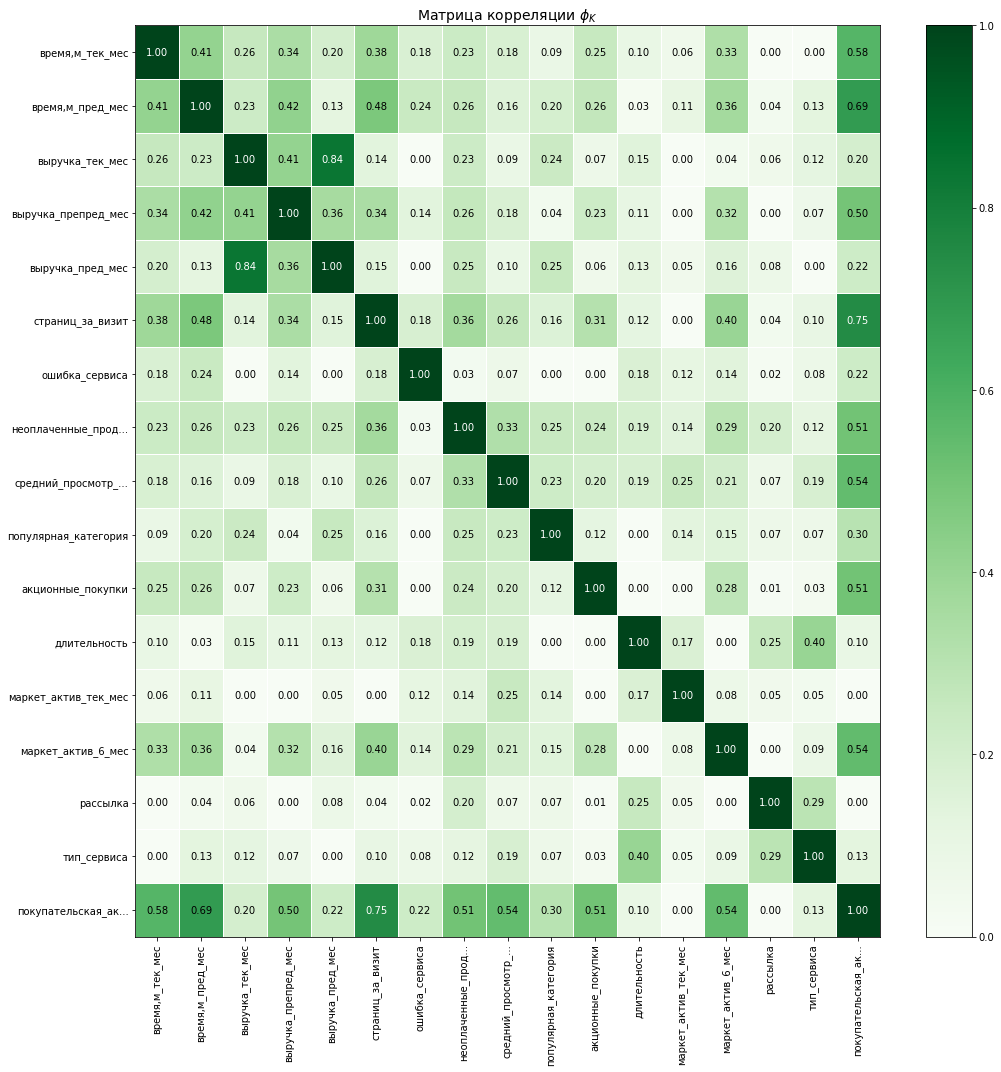

In [53]:
phik_overview = full_df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 15))
plt.tight_layout()

Видим достаточно высокую корреляцию между признаками, описывающими выручку за разные периоды. Избавимся от корреляции путем создания новых признаков - разности между выручкой текущего и предыдущего месяцев, а также предыдущего и препредыдущего.

In [54]:
full_df['выручка_тек_мес-пред_мес'] = full_df['выручка_тек_мес'] - full_df['выручка_пред_мес']
full_df['выручка_пред_мес-препред_мес'] = full_df['выручка_пред_мес'] - full_df['выручка_препред_мес']
full_df = full_df.drop(['выручка_пред_мес','выручка_препред_мес'], axis = 1)

In [55]:
interval_cols = full_df.select_dtypes('number').columns.tolist()
interval_cols

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_тек_мес',
 'время,м_пред_мес',
 'время,м_тек_мес',
 'выручка_тек_мес-пред_мес',
 'выручка_пред_мес-препред_мес']

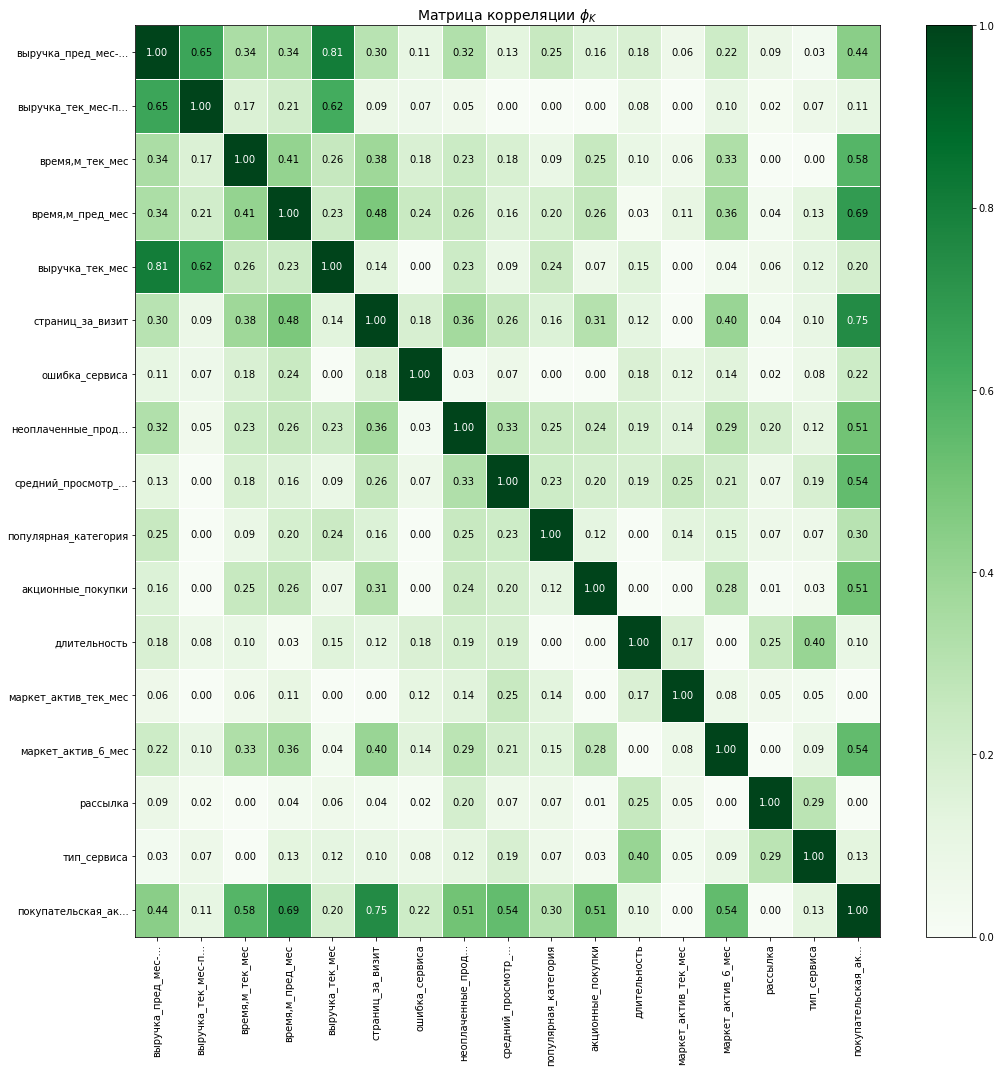

In [56]:
phik_overview = full_df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 15))
plt.tight_layout()

**Вывод:** корреляционный анализ показал наличие корреляции между признаками, описывающими выручку за разные периоды, от которой избавились путем создания новых признаков - разностью между выручкой текущего и предыдущего месяцев, а также предыдущего и препредыдущего.

## Обучение модели МО

Перед обучением переобозначим признаки: так как нам необходимо найти всех пользователей, у которых снизилась покупательская активность, зашифруем 1 - снизилась, 0 - прежний уровень.

In [57]:
def activity_to_int(activity):
    if activity == 'снизилась':
        return 1
    else:
        return 0
full_df['покупательская_активность'] = full_df['покупательская_активность'].map(activity_to_int)

Разделим на тренировочную и тестовую выборки с сохранением доли целевого признака

In [58]:
RANDOM_STATE=42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
full_df.drop(['покупательская_активность'], axis = 1),
full_df['покупательская_активность'],
random_state = RANDOM_STATE,
test_size = TEST_SIZE,
stratify = full_df['покупательская_активность'])
X_train.shape, X_test.shape

((972, 16), (324, 16))

Определим столбцы, подлежащие энкодингу и стандартизации

In [59]:
ohe_columns = X_train.columns.drop(interval_cols).tolist()
num_columns = interval_cols

ohe_columns, '\n', '\n', num_columns

(['тип_сервиса', 'рассылка', 'популярная_категория'],
 '\n',
 '\n',
 ['маркет_актив_6_мес',
  'маркет_актив_тек_мес',
  'длительность',
  'акционные_покупки',
  'средний_просмотр_категорий_за_визит',
  'неоплаченные_продукты_штук_квартал',
  'ошибка_сервиса',
  'страниц_за_визит',
  'выручка_тек_мес',
  'время,м_пред_мес',
  'время,м_тек_мес',
  'выручка_тек_мес-пред_мес',
  'выручка_пред_мес-препред_мес'])

Создадим элемент класса, преобразовывающий входящие признаки

In [60]:
preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop = 'first'), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
remainder = 'passthrough')

Финальный пайплайн

In [61]:
final_pipe = Pipeline(
[('preprocessor',preprocessor),
 ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))]
)

Сетка параметров, по которой происходит рандомизированный поиск

In [62]:
param_grid = [
    {'models': [LogisticRegression(random_state = RANDOM_STATE, penalty = 'l1', solver = 'liblinear')],
     'models__C': range(1,6),
     'preprocessor__num':[MinMaxScaler(),StandardScaler(), 'passthrough']
     ,'preprocessor__ohe':[OrdinalEncoder(),OneHotEncoder(drop = 'first')]
    },
    {'models':[SVC(random_state=RANDOM_STATE, probability = True)],
     'models__kernel':['rbf','poly','sigmoid'],
     'models__C': range(1,6),
     'preprocessor__num':[MinMaxScaler(),StandardScaler(), 'passthrough']
     ,'preprocessor__ohe':[OrdinalEncoder(),OneHotEncoder(drop = 'first')]
    },
    {'models':[DecisionTreeClassifier(random_state = RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5),
     'preprocessor__num': [MinMaxScaler(),StandardScaler(), 'passthrough']
     ,'preprocessor__ohe':[OrdinalEncoder(),OneHotEncoder(drop = 'first')] 
    },
    {'models':[KNeighborsClassifier()],
     'models__n_neighbors': range(2,10),
     'models__metric':['euclidean','cityblock'],
     'preprocessor__num': [StandardScaler(), MinMaxScaler()]
     ,'preprocessor__ohe':[OrdinalEncoder(),OneHotEncoder(drop = 'first')]
    }
]

Создаем элемент класса рандомизированного поиска лучших параметров.

В качестве метрики используем roc-auc, так как дисбаланс классов невелик, а заказчик не передал требования по желаемому балансу полноты и точности.

In [63]:
randomized_search = RandomizedSearchCV(
final_pipe,
param_grid,
cv = 5,
random_state = RANDOM_STATE,
n_jobs = -1,
n_iter = 15,
scoring = 'roc_auc')

In [64]:
randomized_search.fit(X_train,y_train)
print(f'Метрика roc-auc для лучшей модели:\n{randomized_search.best_score_:.3f}')
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика roc-auc для лучшей модели:
0.899

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OrdinalEncoder(),
                                                  ['тип_сервиса', 'рассылка',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_серви

In [65]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
12,1,"SVC(C=1, probability=True, random_state=42)",0.898789,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."
1,2,"LogisticRegression(penalty='l1', random_state=...",0.896102,{'preprocessor__ohe': OneHotEncoder(drop='firs...
4,3,"LogisticRegression(penalty='l1', random_state=...",0.896028,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."
6,4,"LogisticRegression(penalty='l1', random_state=...",0.895945,{'preprocessor__ohe': OneHotEncoder(drop='firs...
7,5,KNeighborsClassifier(),0.891796,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."
10,6,KNeighborsClassifier(),0.886665,{'preprocessor__ohe': OneHotEncoder(drop='firs...
13,7,KNeighborsClassifier(),0.882617,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."
9,8,KNeighborsClassifier(),0.863312,{'preprocessor__ohe': OneHotEncoder(drop='firs...
2,9,KNeighborsClassifier(),0.859675,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."
5,10,DecisionTreeClassifier(random_state=42),0.824962,"{'preprocessor__ohe': OrdinalEncoder(), 'prepr..."


Так как для дальнейшего анализа необходима ленийная модель, в качетсве лучшей модели выбираем логистическую регрессию

In [66]:
result.query('rank_test_score == 2')['params'][1]

{'preprocessor__ohe': OneHotEncoder(drop='first'),
 'preprocessor__num': StandardScaler(),
 'models__C': 3,
 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}

Таким образом, наилучшей подходящей моделью с бОльшим значением roc-auc является логистическая регрессия с лассо-регрессией, коэффциентом регуляризации C = 3, энкодинг с помощью OHE, стандартизация с помощью StandardScaler.

In [67]:
X_train = pd.DataFrame(data = preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
X_test = pd.DataFrame(data = preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [68]:
model = LogisticRegression(penalty='l1', random_state=42, solver='liblinear', C = 3)
model.fit(X_train,y_train)

LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

In [69]:
print(f'Метрика roc-auc для тестовых данных:\n\
{roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.3f}')

Метрика roc-auc для тестовых данных:
0.916


Полученное значение метрики достаточно высоко, что говорит о высокой степени обученности.

Дальнейший анализ признаков поможет выбрать необходимые и избавиться от лишних.

**Вывод:** наилучшей подходящей моделью с бОльшим средним значением roc-auc на тренировочной выборке равным 0.896 является логистическая регрессия с лассо-регрессией, коэффциентом регуляризации с= 4, энкодинг с помощью OrdinalEncoder, стандартизация с помощью StandardScaler.

## Анализ важности признаков

Построим диаграмму значений Шепли

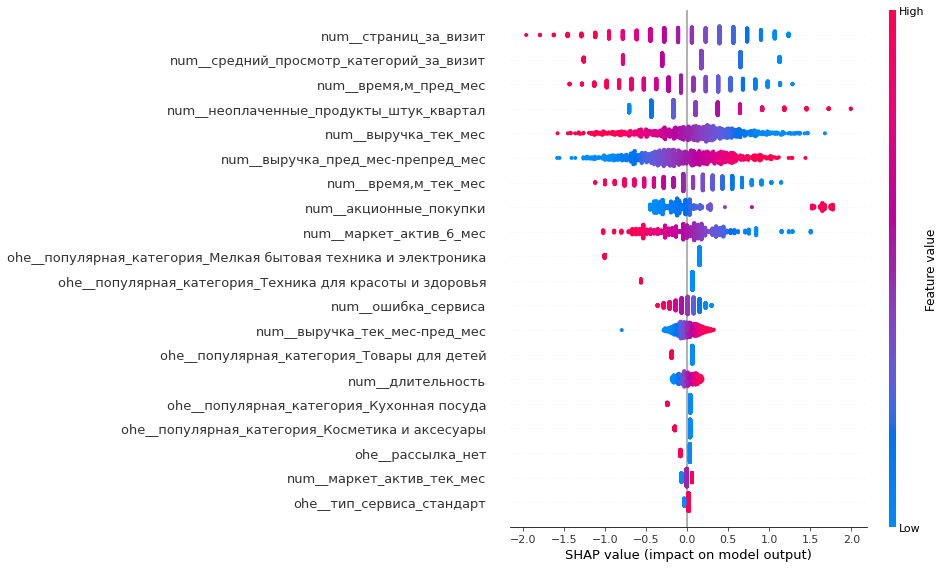

In [70]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values, max_display = 25)

Построим столбчатую диаграмму вклада признаков в прогноз модели

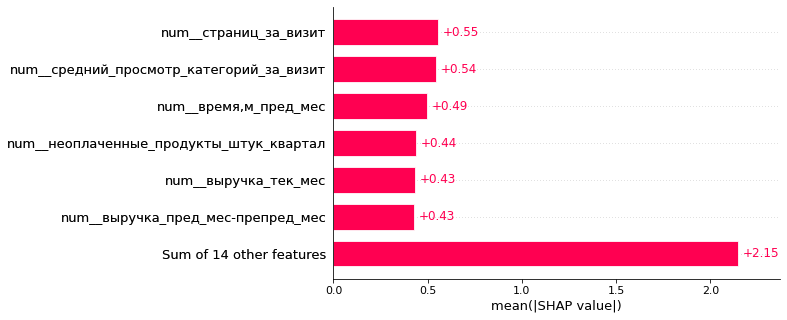

In [71]:
shap.plots.bar(shap_values, max_display = 7)

**Вывод:** Анализируя построенные графики можем заметить следующее: ***наиболее значимые для модели признаки*** : количество посещенных страниц и среднее число просмотренных категорий за визит, время на сайте в предыдущем месяце, количество неоплаченных товаров в корзине, а также выручка в текущем месяце. При этом чем выше у пользователя среднее число просмотренных категорий и посещенных страниц за визит, время,проведенное на сайте в предыдущем месяце и выручка - тем больше вероятность того, что покупательская активность не изменится, в то время как увеличение числа неоплаченных продуктов говорит о высокой вероятности того, что покупательская активность снизится. ***Наименее значимые для модели признаки***: тип сервиса, наличие согласия на рассылку, а также количество маркетинговых коммуникаций в текущем месяце.

Логично предположить, что количество посещенных страниц и среднее число просмотренных категорий за визит, время на сайте в предыдущем месяце, количество неоплаченных товаров в корзине имеют причинно-следственную связь с покупательской активностью, в то время как выручка - скорее коррелирует с ней.

Таким образом, с целью снижения мощностных затрат на обучение модели и предсказывание целевого признака, а также уменьшения влияния шума, вносимого маловлияющими признаками можно исключить их из анализа. В качестве рекомендаций можно обратить внимание бизнеса на то, что наименее влияющие признаки непосредственно связаны с работой отдела маркетинга - необходимо проанализировать успешность принятия маркетинговых решений, также заметно, что тип сервиса играет малую роль в сохранении покупательской активности, а следовательно пользователи, решившие использовать премиум подписку, не начинают тратить больше, не видя в этом выгоды. Дополнительно необходимо подчеркнуть, что на сохранение покупательской способности положительно влияют признаки, связанные с привлекательностю карточки товара: среднее число просмотренных категорий за визит, количество страниц, посещенных за визит.

## Сегментация покупателей

### Покупатели с высокой долей покупок товаров по акции и высокой вероятностью снижения покупательской активности

Добавим в объединенный ДФ вероятность снижения покупательской активности и информацию о среднемесячной прибыли продавца за последние 3 месяца.

In [72]:
full_df['вероятность_снижения']=(
    model.predict_proba(
        pd.DataFrame(
            data = preprocessor.transform(full_df.drop(['покупательская_активность'], axis =1)),
            columns = preprocessor.get_feature_names_out())
    )[:,1]
)
full_df = full_df.join(money_df)

full_df['выручка_пред_мес'] = full_df['выручка_тек_мес'] - full_df['выручка_тек_мес-пред_мес']
full_df['выручка_препред_мес'] = full_df['выручка_пред_мес'] - full_df['выручка_пред_мес-препред_мес']

full_df.head()

,покупательская_активность,тип_сервиса,рассылка,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_тек_мес,"время,м_пред_мес","время,м_тек_мес",выручка_тек_мес-пред_мес,выручка_пред_мес-препред_мес,вероятность_снижения,прибыль,выручка_пред_мес,выручка_препред_мес
id,,,,,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,...,5,4971.6,12,10,-244.4,744.0,0.913018,4.16,5216.0,4472.0
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,...,5,5058.4,8,13,-399.1,631.5,0.430132,3.13,5457.5,4826.0
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,...,4,6610.4,11,13,452.4,1365.0,0.796274,4.87,6158.0,4793.0
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,...,2,5872.5,8,11,65.0,1213.5,0.961149,4.21,5807.5,4594.0
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,...,4,5388.5,10,10,650.0,-385.5,0.671765,3.95,4738.5,5124.0


In [73]:
interval_cols = full_df.drop(['выручка_тек_мес-пред_мес','выручка_пред_мес-препред_мес'], axis = 1).select_dtypes('number').columns.tolist()

Выделим первый сегмент пользователей

In [74]:
first_segment = full_df.query('акционные_покупки > 0.8 and вероятность_снижения > 0.8').copy()
first_look(first_segment)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 215352 to 216604
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            116 non-null    int64  
 1   тип_сервиса                          116 non-null    object 
 2   рассылка                             116 non-null    object 
 3   маркет_актив_6_мес                   116 non-null    float64
 4   маркет_актив_тек_мес                 116 non-null    int64  
 5   длительность                         116 non-null    int64  
 6   акционные_покупки                    116 non-null    float64
 7   популярная_категория                 116 non-null    object 
 8   средний_просмотр_категорий_за_визит  116 non-null    int64  
 9   неоплаченные_продукты_штук_квартал   116 non-null    int64  
 10  ошибка_сервиса                       116 non-null    int64  
 11  страниц_за_визит        

None

,покупательская_активность,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_тек_мес,"время,м_пред_мес","время,м_тек_мес",выручка_тек_мес-пред_мес,выручка_пред_мес-препред_мес,вероятность_снижения,прибыль,выручка_пред_мес,выручка_препред_мес
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000
mean,0.982759,3.486207,3.948276,603.939655,0.943017,2.482759,4.336207,3.939655,4.250000,5252.981897,9.836207,10.068966,313.882759,316.969828,0.962587,3.848966,4939.099138,4622.12931
std,0.130734,1.065090,0.683276,224.426972,0.033885,1.122751,2.481038,1.799946,2.042484,894.800906,2.384530,2.412735,378.043442,768.027109,0.045223,0.962716,836.064521,233.98653
min,0.000000,0.900000,3.000000,167.000000,0.890000,1.000000,0.000000,1.000000,1.000000,3232.200000,5.000000,4.000000,-551.200000,-1605.000000,0.802066,1.330000,3146.000000,4098.00000
25%,1.000000,3.000000,3.000000,451.750000,0.930000,2.000000,3.000000,3.000000,3.000000,4617.875000,8.000000,8.750000,22.100000,-106.750000,0.956566,3.177500,4405.250000,4447.75000
50%,1.000000,3.800000,4.000000,600.000000,0.940000,2.000000,4.000000,4.000000,4.000000,5250.900000,10.000000,10.000000,306.150000,465.000000,0.981101,4.010000,5072.000000,4653.50000
75%,1.000000,4.100000,4.000000,788.000000,0.980000,3.000000,6.000000,5.000000,5.000000,5803.425000,11.000000,11.000000,578.825000,848.625000,0.991690,4.422500,5555.375000,4774.75000
max,1.000000,5.700000,5.000000,1064.000000,0.990000,6.000000,10.000000,8.000000,13.000000,7799.400000,16.000000,18.000000,1332.500000,1846.500000,0.999085,6.730000,6716.500000,5532.00000


,покупательская_активность,тип_сервиса,рассылка,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_тек_мес,"время,м_пред_мес","время,м_тек_мес",выручка_тек_мес-пред_мес,выручка_пред_мес-препред_мес,вероятность_снижения,прибыль,выручка_пред_мес,выручка_препред_мес
id,,,,,,,,,,,,,,,,,,,,,
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,...,2,5872.5,8,11,65.0,1213.5,0.961149,4.21,5807.5,4594.0
215364,1,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,...,3,5484.8,11,9,-310.7,853.5,0.974929,2.67,5795.5,4942.0
215365,1,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,...,5,4799.3,6,10,222.3,387.0,0.918166,3.65,4577.0,4190.0
215373,1,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,...,3,5161.1,10,8,529.1,339.0,0.988700,3.69,4632.0,4293.0
215374,1,стандарт,нет,2.9,5,268,0.98,Домашний текстиль,6,3,...,2,5720.9,11,8,-41.6,1096.5,0.958928,4.08,5762.5,4666.0
215375,1,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,...,4,5633.1,8,9,379.6,538.5,0.971869,4.18,5253.5,4715.0
215376,1,стандарт,да,2.4,3,534,0.98,Домашний текстиль,4,1,...,4,6209.2,8,9,148.2,1338.0,0.972861,4.26,6061.0,4723.0
215379,1,стандарт,нет,3.4,4,436,0.98,Товары для детей,3,0,...,5,4394.9,10,15,94.9,-60.0,0.884475,4.42,4300.0,4360.0
215386,1,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,...,5,4478.5,14,8,1332.5,-1605.0,0.971230,4.05,3146.0,4751.0


#### Анализ категорийных признаков

'Количество уникальных значений в столбце равно 2'

стандарт    74
премиум     42
Name: тип_сервиса, dtype: int64

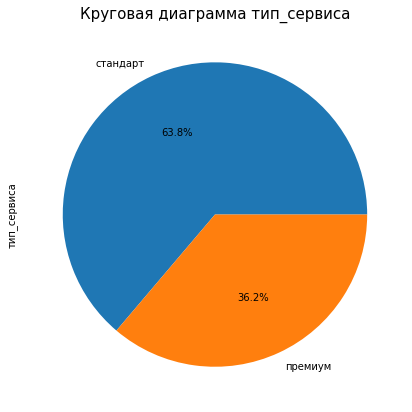

'Количество уникальных значений в столбце равно 2'

да     85
нет    31
Name: рассылка, dtype: int64

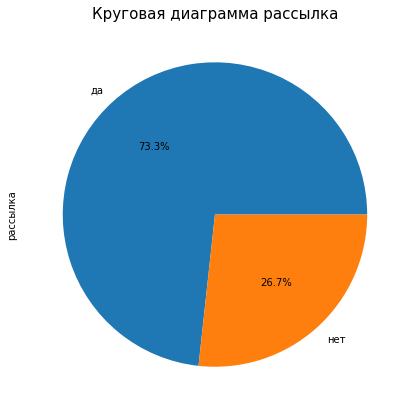

'Количество уникальных значений в столбце равно 6'

Товары для детей                        40
Домашний текстиль                       24
Косметика и аксесуары                   23
Кухонная посуда                         16
Техника для красоты и здоровья           9
Мелкая бытовая техника и электроника     4
Name: популярная_категория, dtype: int64

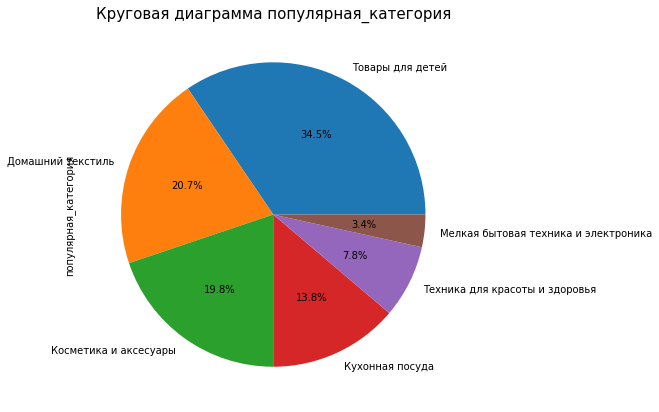

In [75]:
for column in full_df.drop(['выручка_тек_мес-пред_мес','выручка_пред_мес-препред_мес'], axis = 1).columns.drop(interval_cols).tolist():
    cat_feature(first_segment[column])

In [76]:
pd.pivot_table(
    data = first_segment,
    index = 'популярная_категория',
    values = ['выручка_тек_мес','выручка_пред_мес','выручка_препред_мес'],
    aggfunc = 'mean'
).reindex(columns = ['выручка_препред_мес','выручка_пред_мес','выручка_тек_мес'])

,выручка_препред_мес,выручка_пред_мес,выручка_тек_мес
популярная_категория,,,
Домашний текстиль,4661.208333,5085.895833,5402.229167
Косметика и аксесуары,4670.913043,5344.043478,5699.847826
Кухонная посуда,4656.312500,5493.687500,5898.962500
Мелкая бытовая техника и электроника,4684.750000,5260.750000,5647.825000
Техника для красоты и здоровья,4529.222222,4087.500000,4503.355556
Товары для детей,4571.600000,4555.787500,4777.275000


Из проведенного анализа видно, что тип сервиса и наличие рассылки пропорционально тождественны материнскому датасету. Также можно заметить, что для категории пользователей с высокой долей покупок товаров по акции и высокой вероятностью снижения покупательской активности свойственно выбирать категории товаров "товары для детей", "косметика и аксессуары", "домашний текстиль". Также можно заметить, что по всем категориям кроме "техника для красоты и здоровья" и "товары для детей" наблюдается видимое увеличение выручки от месяца к месяцу. По категории "техника для красоты и здоровья" видно снижение выручки в предыдущем месяце и возврат на прежний уровень в нынешнем. По категории "товары для детей" видна стагнация выручки.

Соответственно так как по наиболее популярной категории наблюдается стагнация в выручке необходимо предпринять меры по вовлечению покупателей.

#### Анализ численных признаков

count    116.000000
mean       0.982759
std        0.130734
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: покупательская_активность, dtype: float64

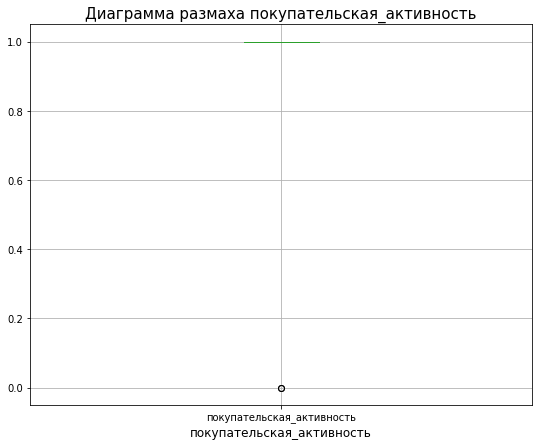

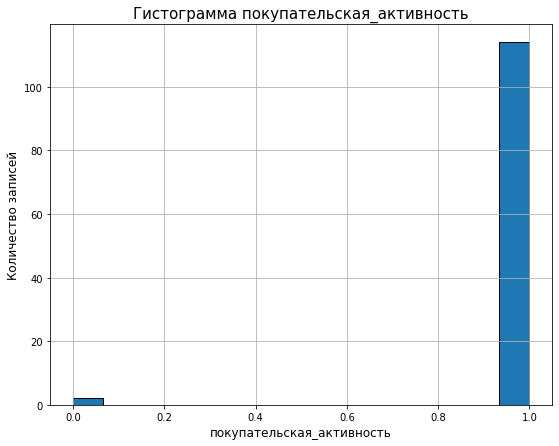

count    116.000000
mean       3.486207
std        1.065090
min        0.900000
25%        3.000000
50%        3.800000
75%        4.100000
max        5.700000
Name: маркет_актив_6_мес, dtype: float64

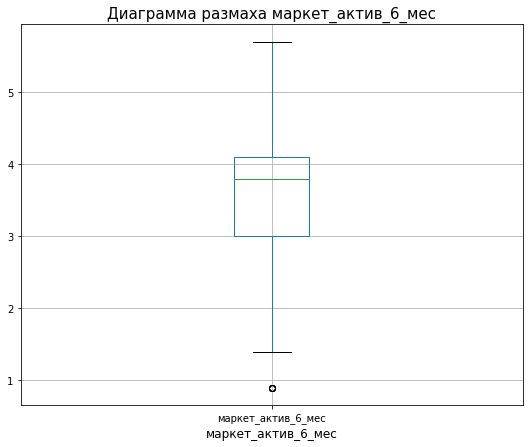

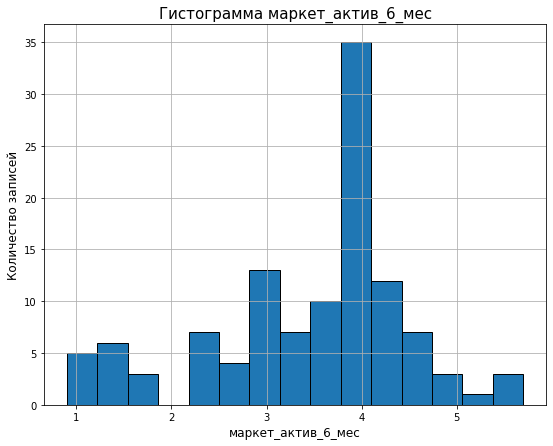

count    116.000000
mean       3.948276
std        0.683276
min        3.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: маркет_актив_тек_мес, dtype: float64

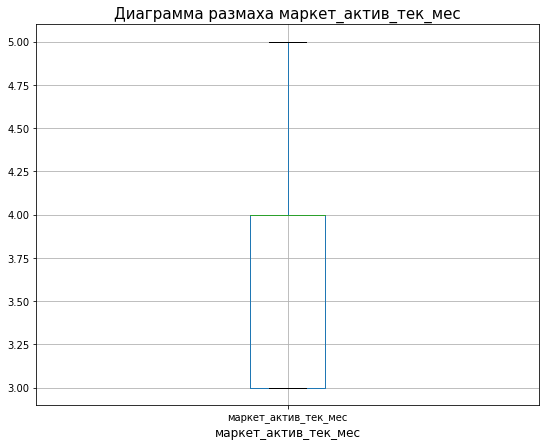

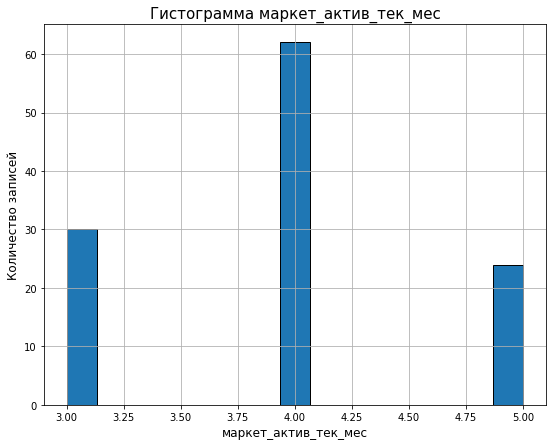

count     116.000000
mean      603.939655
std       224.426972
min       167.000000
25%       451.750000
50%       600.000000
75%       788.000000
max      1064.000000
Name: длительность, dtype: float64

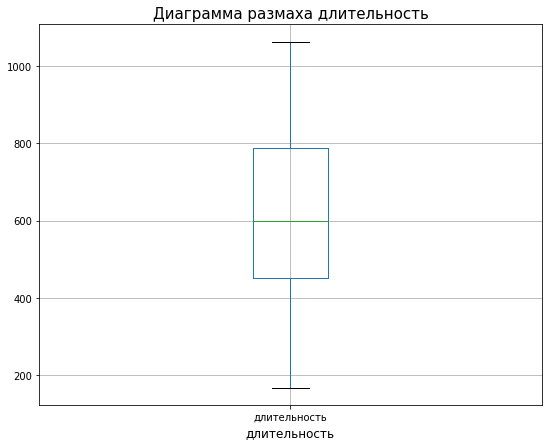

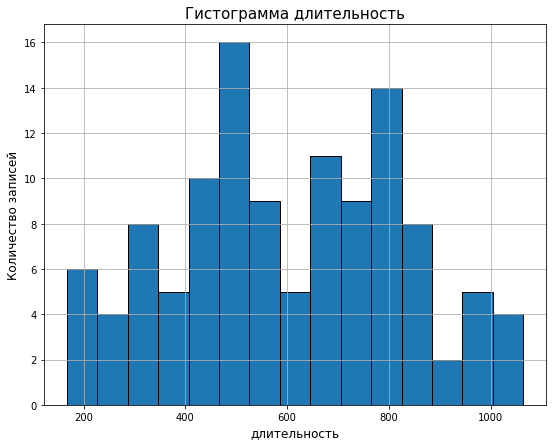

count    116.000000
mean       0.943017
std        0.033885
min        0.890000
25%        0.930000
50%        0.940000
75%        0.980000
max        0.990000
Name: акционные_покупки, dtype: float64

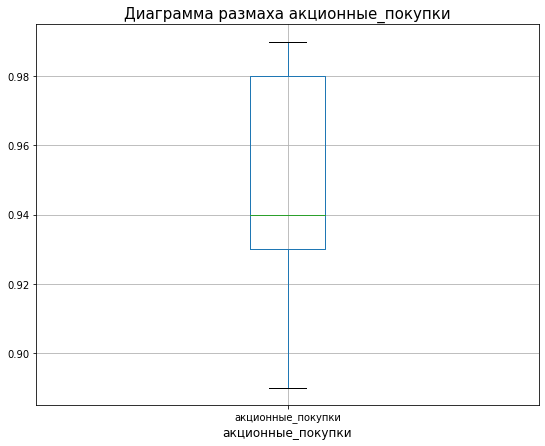

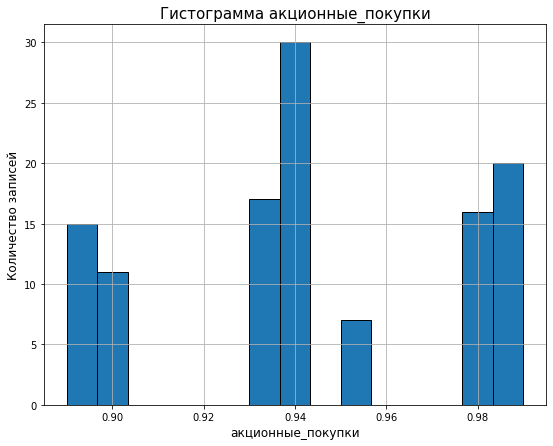

count    116.000000
mean       2.482759
std        1.122751
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

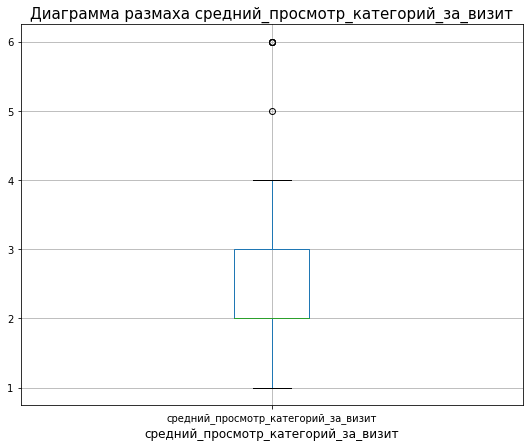

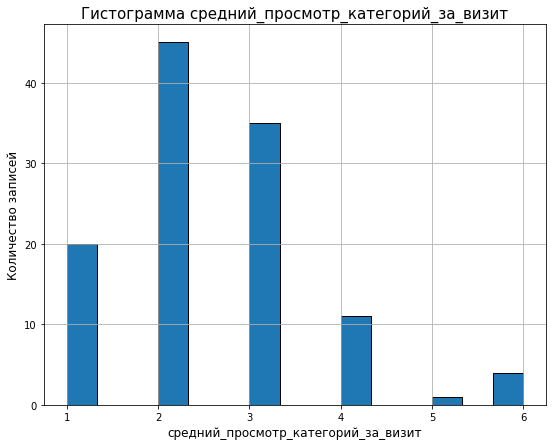

count    116.000000
mean       4.336207
std        2.481038
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

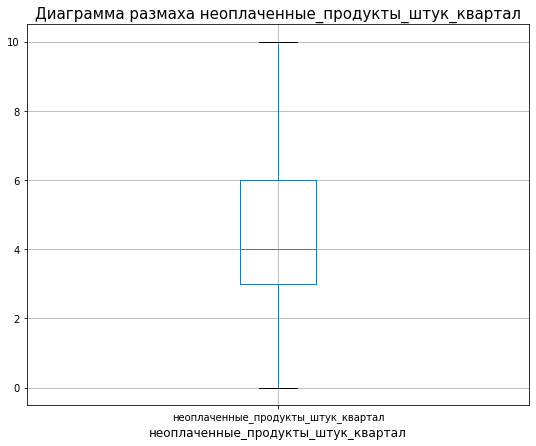

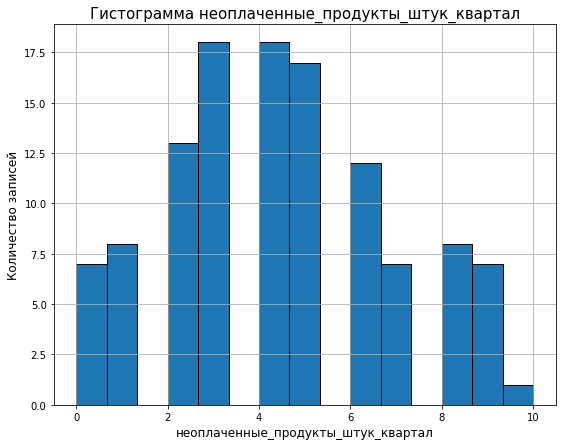

count    116.000000
mean       3.939655
std        1.799946
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        8.000000
Name: ошибка_сервиса, dtype: float64

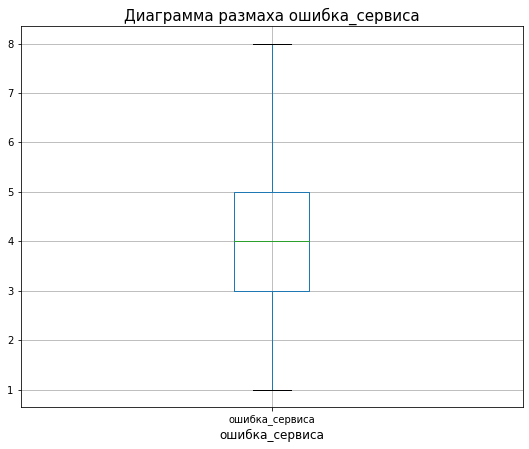

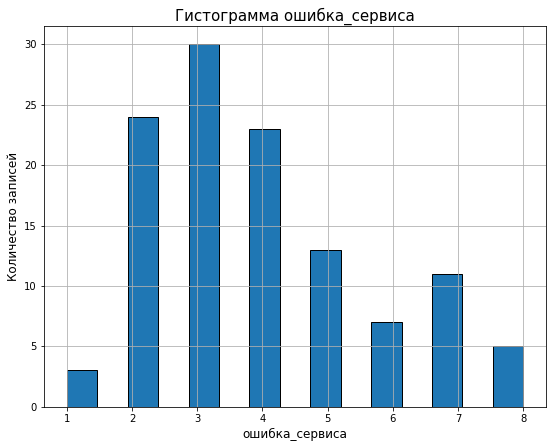

count    116.000000
mean       4.250000
std        2.042484
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       13.000000
Name: страниц_за_визит, dtype: float64

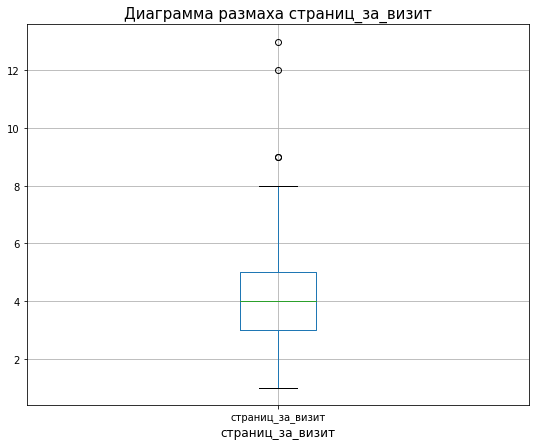

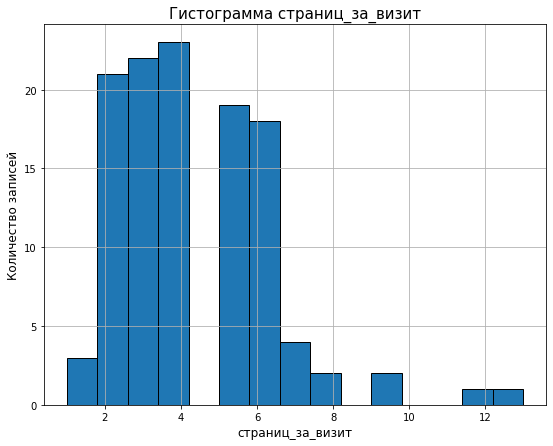

count     116.000000
mean     5252.981897
std       894.800906
min      3232.200000
25%      4617.875000
50%      5250.900000
75%      5803.425000
max      7799.400000
Name: выручка_тек_мес, dtype: float64

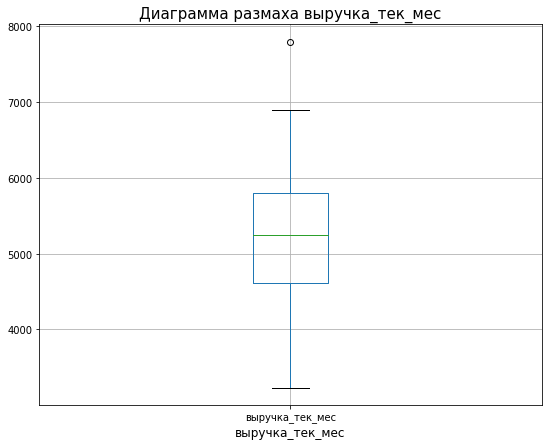

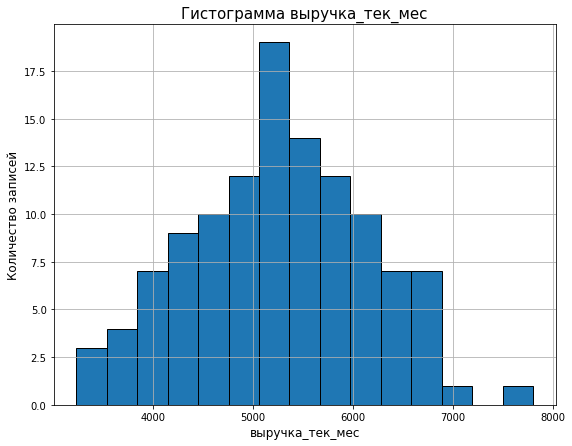

count    116.000000
mean       9.836207
std        2.384530
min        5.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       16.000000
Name: время,м_пред_мес, dtype: float64

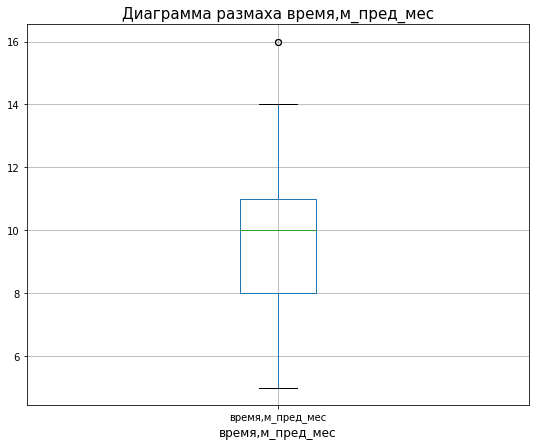

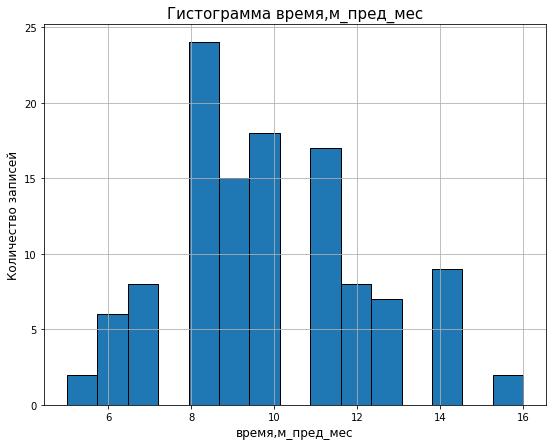

count    116.000000
mean      10.068966
std        2.412735
min        4.000000
25%        8.750000
50%       10.000000
75%       11.000000
max       18.000000
Name: время,м_тек_мес, dtype: float64

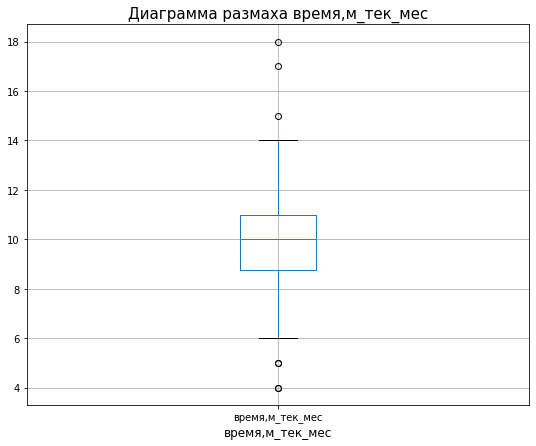

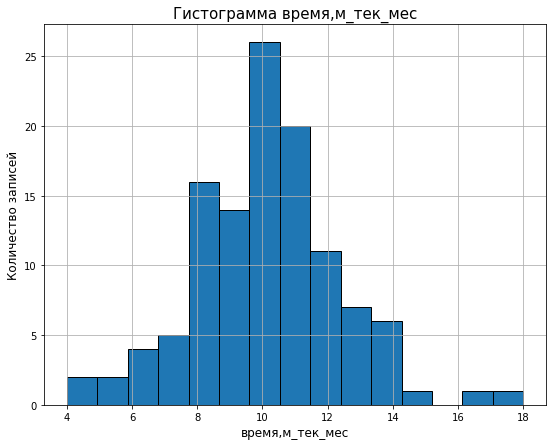

count    116.000000
mean       0.962587
std        0.045223
min        0.802066
25%        0.956566
50%        0.981101
75%        0.991690
max        0.999085
Name: вероятность_снижения, dtype: float64

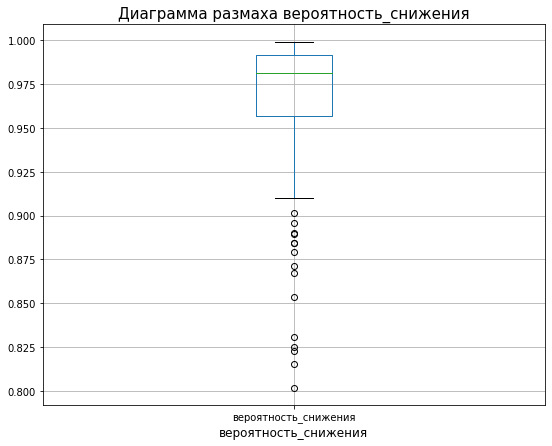

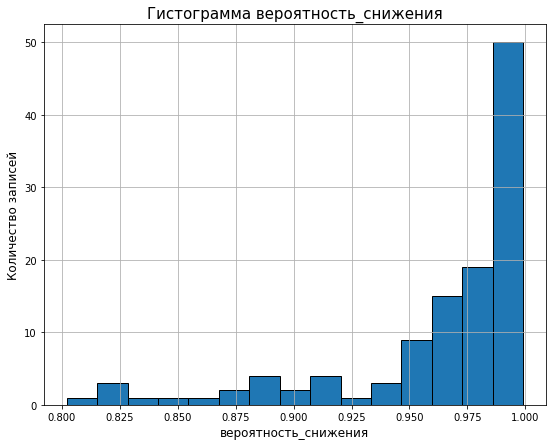

count    116.000000
mean       3.848966
std        0.962716
min        1.330000
25%        3.177500
50%        4.010000
75%        4.422500
max        6.730000
Name: прибыль, dtype: float64

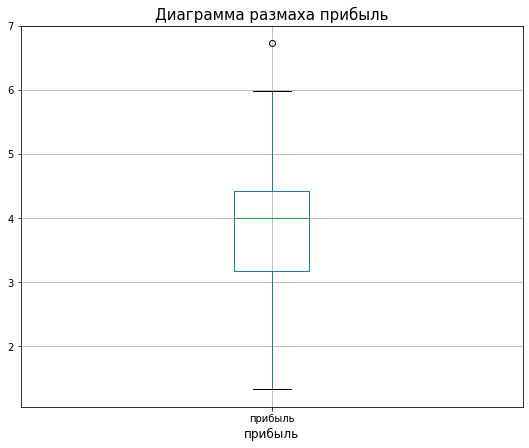

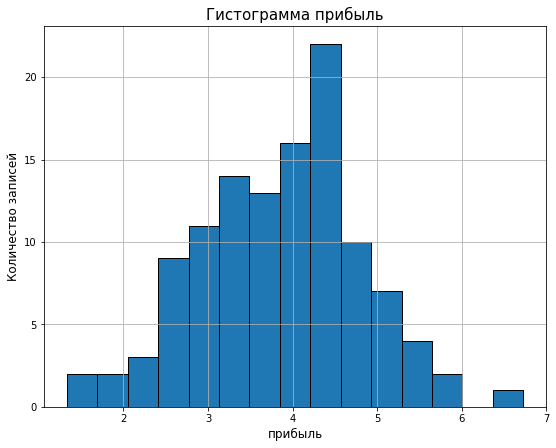

count     116.000000
mean     4939.099138
std       836.064521
min      3146.000000
25%      4405.250000
50%      5072.000000
75%      5555.375000
max      6716.500000
Name: выручка_пред_мес, dtype: float64

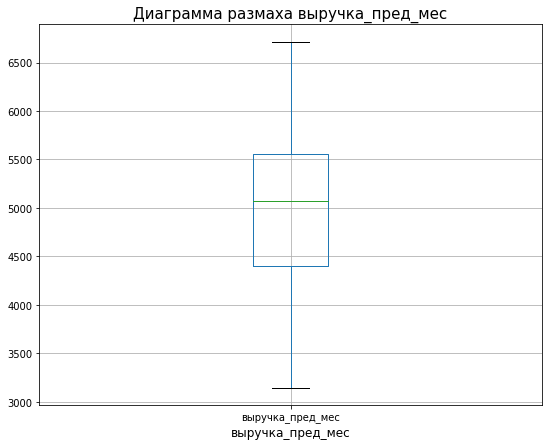

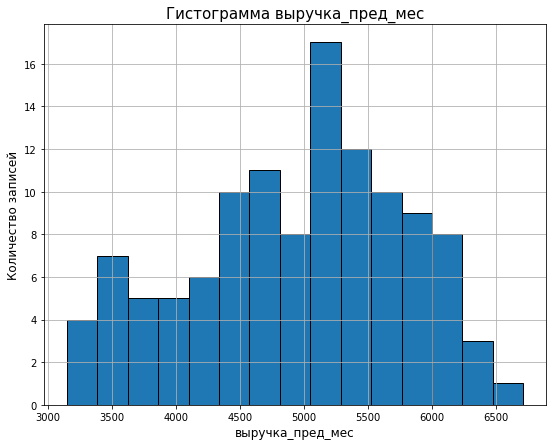

count     116.00000
mean     4622.12931
std       233.98653
min      4098.00000
25%      4447.75000
50%      4653.50000
75%      4774.75000
max      5532.00000
Name: выручка_препред_мес, dtype: float64

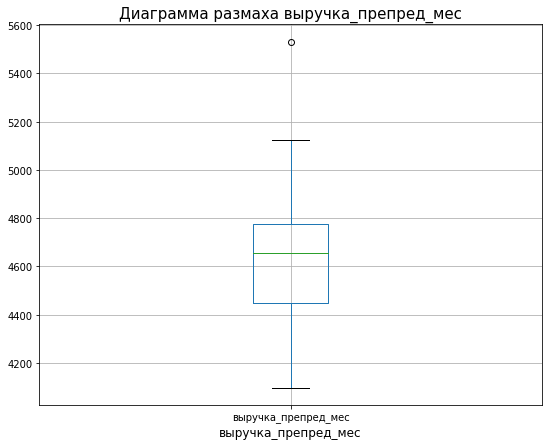

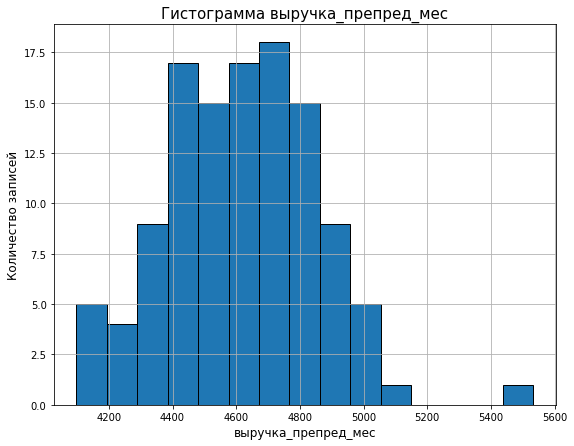

In [77]:
for column in interval_cols:
    num_feature(first_segment[column])

Из анализа численных признаков заметно: большая часть пользователей первого сегмента просматривают от 1 до 3 категорий за визит, зарегестрировались ~500 или ~800 дней назад, посещают до 6 страниц за визит, тратят в среднем меньше времени на визит, а также прибыль с них в среднем ниже, чем с остальных пользователей сервиса.

#### Возможные рекомендации

**Вывод:** исходя из анализа можно зарегестрировать следующие паттерны поведения пользователей с высокой долей покупок товаров по акции и высокой вероятностью снижения покупательской активности:
* зарегестрировались ~500 или ~800 дней назад - это говорит о том, что скорее всего данные пользователи были завлечены проводимыми акциями сервиса;
* в среднем просматривают до 3-ех категорий товаров, наиболее вероятно это будут "товары для детей", "косметика и аксессуары", "домашний текстиль";
* просматривают до 6 карточек товаров и тратят на это в среднем меньше времени, нежели остальные пользователи;
* выручка от них в среднем меньше чем от других категорий пользователей;
* в рассматриваемый промежуток выручка по самой популярной категории не изменяется, в отличие от остальных категорий, выручка от которых растет.

Исходя из паттернов видится следующая рекомендация: для данных пользователей в системе выдачи рекомендуемых к покупке товаров сосредоточится на категориях "товары для детей", "косметика и аксессуары", "домашний текстиль", ввести (если еще нет) в карточку товара возможность публикации короткой видеопрезентации товара с возможностью переключения на следующий рекомендуемый товар (из той же категории + 1/6 свайпов предлагает пользователю товар из одной из 3-ех других категорий) свайпом вниз/вверх для ускорения перехода пользователя от товара к товару. Также можно закупить у поставщиков из дружественных стран более дешевые товары вышеназванных категорий и провести распродажу с высокой начальной ценой товара и соответствующей большой скидкой для привлечения клиентов данной категории. Вероятная причина стагнации выручки по категории "товары для детей" видится в малом ассортименте товара, что также может вести за собой снижение числа просматриваемых карточек товаров, соответственно стоит рассмотреть возможность увеличения разнообразия товара категории "товары для детей".

## Выводы

В настоящей работе было проведено исследование данных интернет-магазина "В один клик", разработаны и определены лучшиие модели для определения вероятности снижения покупательской активности.

Исследование:

**Предобработка данных**, которая включала приведение к нижнему регистру наименований столбцов, а также значений в столбце "покупательская_активность", проверено наличие дубликатов и пропусков, исправлены ошибки, допущенные при записи данных. Данные достаточно чистые - пропуски, явные дубликаты в данных отсутствуют.

**Исследовательский анализ данных**, в ходе которого были проанализированы: покупательская активность: большинство людей сохраняют текущий уровень, прибыль: распределение стремится к нормальному со средним около 4-ёх, ***признаки, описывающие коммуникацию сотрудников компании с клиентом***: большинство клиентов согласно на получение рассылки, всего представлено 2 типа сервиса, преобладающее большинство пользователей предпочитает стандартный, большинство клиентов в среднем коммуницирует с сотрудниками 4 раза в месяц(в среднем за последние 6 месяцев), также как и в текущем месяце, в последнее время стало меньше новых пользователей; ***признаки, описывающие продуктовое поведение***: наиболее популярные категории "товары для детей", "косметика и аксессуары", "домашний текстиль", пользователи наиболее часто просматривают 3 категории за визит, более половины клиентов имеет от 0 до 3 неоплаченных товаров в корзине; ***признаки, описывающие поведение пользователей на сайте***: в последнее время длительность визита уменьшается, число сбоев распределено нормально, большинство пользователей столкнулись со сбоями 4 раза, в среднем люди просматривают 8 страниц за визит; ***признаки, описывающие финансовое поведение пользователей***: большинство людей имеет до половины покупок по акции, однако же есть другая категория, у которых доля акционных товаров от 80 до 100%, от месяца к месяцу выручка пользователей растет.

В дополнение стоит выделить признаки **"среднее количество страниц за визит", "среднее количество просмотренных категорий товаров за визит", "число неоплаченных товаров в корзине за последние 3 месяца", "доля покупок по акции от общего числа покупок за последние 6 месяцев", "число сбоев"**, которые особенно сильно различаются у покупателей с прежней и снизившейся покупательской активностью.

**Объединение таблиц**: проведено объединение таблиц по признаку "id" с обозначением периода.

**Корреляционный анализ**, в ходе которого построена матрица корреляций Фика, которая показала наличие корреляции между признаками, описывающими выручку за разные периоды, от которой избавились путем создания новых признаков - разностью между выручкой текущего и предыдущего месяцев, а также предыдущего и препредыдущего.

**Обучение моделей МО**: с помощью рандомизированного поиска гиперпараметров модели найдена модель, имеющая наибольшее значение roc-auc на тренировочной выборке. Лучшая модель это `SVC(probability=True, random_state=42)`. Значение метрики на тренировочных данных равно 0.899, что является высоким показателем качества решения. Однако же для дальнейшего анализа значимости признаков была выбрана лучшая линейная модель `LogisticRegression(penalty='l1', random_state=42, solver='liblinear', C = 3)` для которой значение выбранной метрики на тренировочных данных равно 0.896, на тестовой - 0.916. Полученные значения метрики достаточно высоки и близки, что говорит о высокой степени обученности и в то же время не достигнута переобученность.

**Анализ важности признаков** анализируя построенные графики Шепли-значений можем заметить следующее: ***наиболее значимые для модели признаки*** : количество посещенных страниц и среднее число просмотренных категорий за визит, время на сайте в предыдущем месяце, количество неоплаченных товаров в корзине, а также выручка в текущем месяце; ***наименее значимые для модели признаки***: тип сервиса, наличие согласия на рассылку, а также количество маркетинговых коммуникаций в текущем месяце.

**Проанализирован сегмент покупателей с высокой долей покупок акционных товаров и высокой вероятностью снижения покупательской активности**: зарегестрировались ~500 или ~800 дней назад, в среднем просматривают до 3-ех категорий товаров, наиболее вероятно это будут "товары для детей", "косметика и аксессуары", "домашний текстиль", просматривают до 6 карточек товаров и тратят на это в среднем меньше времени, нежели остальные пользователи, выручка от них в среднем меньше чем от других категорий пользователей, в рассматриваемый промежуток выручка по самой популярной категории не изменяется, в отличие от остальных категорий, выручка от которых растет.

**Разработаны рекомендации:** Исходя из паттернов видится следующая рекомендация: для данных пользователей в системе выдачи рекомендуемых к покупке товаров сосредоточится на категориях "товары для детей", "косметика и аксессуары", "домашний текстиль", ввести (если еще нет) в карточку товара возможность публикации короткой видеопрезентации товара с возможностью переключения на следующий рекомендуемый товар (из той же категории + 1/6 свайпов предлагает пользователю товар из одной из 3-ех других категорий) свайпом вниз/вверх для ускорения перехода пользователя от товара к товару. Также можно закупить у поставщиков из дружественных стран более дешевые товары вышеназванных категорий и провести распродажу с высокой начальной ценой товара и соответствующей большой скидкой для привлечения клиентов данной категории. Вероятная причина стагнации выручки по категории "товары для детей" видится в малом ассортименте товара, что также может вести за собой снижение числа просматриваемых карточек товаров, соответственно стоит рассмотреть возможность увеличения разнообразия товара категории "товары для детей".